# **IMPORT MODULES**

In [ ]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 4.2 MB/s 
     |████████████████████████████████| 2.8 MB 24.2 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import itertools
from collections import Counter
import statsmodels.api as sm
from statistics import mean

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import cvxpy as cp

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **DATA PREPROCESSING**

In [ ]:
# 505 Constituents of S&P 500

const = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/constituents.csv')

print("Dimension of Constituents data:", const.shape, "\n")
const.head()

Dimension of Constituents data: (505, 3) 



,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care


In [ ]:
sectors_group = const.groupby(['Sector'])
sectors = list(np.unique(list(const['Sector'])))
sector_key_dict = {}

for s in sectors:
  sector_key_dict[s] = list(sectors_group.get_group(s)['Symbol'])

company_key_dict = dict(zip(list(const['Symbol']), list(const['Sector'])))

In [ ]:
# Y for regression: Returns data for 505 companies

price = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/Last_price_all_consti.csv')
price = price[1:]
price.rename(columns={"#NAME?": "DATE"}, inplace = True)

price['DATE'] = pd.to_datetime(price['DATE'].astype(str),format='%d/%m/%Y')
price.set_index('DATE',inplace= True)
price = price.astype('float')

price['month_date'] = price.index.strftime('%Y-%m')
price = price.groupby("month_date").mean()
return_ = price.pct_change()*100
return_.rename(columns={"month_date": "DATE"}, inplace = True)
return_ = return_[1:]

print("Missing values before front fill:", return_.isna().sum().sum())
return_ = return_.ffill(axis = 0)
print("Missing values after front fill:", return_.isna().sum().sum())
print()

print("Dimension of Returns data:", return_.shape, "\n")
return_.head()

Missing values before front fill: 21763
Missing values after front fill: 21763

Dimension of Returns data: (240, 504) 



,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,-5.171522,-7.417190,NaN,-10.807090,-20.524313,7.555435,-12.291218,-12.251739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,-5.692376,7.155831,NaN,-9.359136,-2.690664,8.775484,8.139595,-11.130918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,3.766459,6.780648,NaN,5.239119,7.543436,-6.167253,5.559309,0.829904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,3.329159,-13.938037,NaN,1.171554,-3.290695,-10.820567,5.597989,5.875967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,8.641872,2.825879,NaN,4.206341,-5.242667,0.900843,-1.118968,7.961793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# MARKET FACTOR: Mkt-Rf data

mkt = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/MarketFactor.CSV')
mkt['DATE'] = pd.to_datetime(mkt['DATE'].astype(str),format='%Y-%m')
mkt['DATE']=mkt.DATE.dt.strftime('%Y-%m')


mkt.rename(columns={"DATE":'month_date'}, inplace = True)
mkt.set_index('month_date', inplace= True)

print("Dimension of Market factor data:", mkt.shape, "\n")
mkt.head()

Dimension of Market factor data: (241, 2) 



,Mkt-RF,RF
month_date,,
2000-01,-4.74,0.41
2000-02,2.45,0.43
2000-03,5.20,0.47
2000-04,-6.40,0.46
2000-05,-4.42,0.50


In [ ]:
# VALUE FACTOR: P/E ratio data for 505 companies

pe_ratio1 = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/PEratio.csv')
pe_ratio2= pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/PEratio_2.csv')
pe_ratio1=pe_ratio1[1:]
pe_ratio2=pe_ratio2[1:]

pe_ratio1.rename(columns={"#NAME?": "DATE"}, inplace = True)
pe_ratio2.rename(columns={"Unnamed: 0": "DATE"}, inplace = True)

pe_ratio1['DATE'] = pd.to_datetime(pe_ratio1['DATE'].astype(str),format='%d/%m/%Y')
pe_ratio1.set_index('DATE',inplace= True)

pe_ratio2['DATE'] = pd.to_datetime(pe_ratio2['DATE'].astype(str),format='%d/%m/%Y')
pe_ratio2.set_index('DATE',inplace= True)

pe_ratio=pd.concat([pe_ratio1,pe_ratio2],axis=1)
pe_ratio = pe_ratio.astype('float')
pe_ratio['month_date'] = pe_ratio.index.strftime('%Y-%m')
pe_ratio = pe_ratio.groupby("month_date").mean()
pe_ratio.rename(columns={"month_date": "DATE"}, inplace = True)
pe_ratio = pe_ratio[1:]

print("Missing values before front fill:", pe_ratio.isna().sum().sum())
pe_ratio = pe_ratio.ffill(axis = 0)
print("Missing values after front fill:", pe_ratio.isna().sum().sum())
print()

print("Dimension of PE ratio data:", pe_ratio.shape, "\n")
pe_ratio.tail()

Missing values before front fill: 28718
Missing values after front fill: 25563

Dimension of PE ratio data: (240, 504) 



,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,SEE UN Equity,CTSH UW Equity,SIVB UW Equity,ISRG UW Equity,TTWO UW Equity,RSG UN Equity,EBAY UW Equity,GS UN Equity,SBAC UW Equity,SRE UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2019-09,8.653372,10.718146,15.423980,11.653124,29.684914,21.651257,11.041752,12.185942,15.709498,25.296798,...,14.847664,15.821262,9.738644,50.909052,93.357056,27.733107,18.405081,8.741445,179.820600,26.768317
2019-10,8.922089,10.793369,14.941029,11.741558,30.476433,21.651257,11.372022,12.268092,15.039488,25.349099,...,14.855485,15.284824,9.546533,51.824813,89.156367,27.571837,17.577595,8.897848,170.904246,27.271954
2019-11,9.980974,11.241085,15.205339,11.605138,33.596671,21.651257,12.976876,13.146087,17.622952,24.817304,...,13.965779,15.548836,10.803280,54.234074,79.518851,27.011995,16.841266,9.788595,158.918688,30.146813
2019-12,9.804807,11.978141,15.559869,11.873502,36.191822,21.651257,12.990084,13.779165,17.420313,25.545021,...,14.071085,15.371380,11.321297,56.288419,79.546948,27.661376,16.978521,10.034073,160.857646,30.866577
2020-01,9.923974,12.363294,15.762538,11.924750,37.139560,21.651257,13.190707,14.095060,17.695180,25.937596,...,14.335450,15.303484,11.602678,56.582297,79.233590,27.828032,17.246600,10.213997,163.458408,31.328850


In [ ]:
# SIZE FACTOR: Market Cap data for 505 companies

mcap1 = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/Marketcap.csv')
mcap2= pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/Market_cap_left.csv')

mcap1=mcap1[1:]
mcap2=mcap2[1:]

mcap1.rename(columns={"#NAME?": "DATE"}, inplace = True)
mcap2.rename(columns={"#NAME?": "DATE"}, inplace = True)

mcap1['DATE'] = pd.to_datetime(mcap1['DATE'].astype(str),format='%d/%m/%Y')
mcap1.set_index('DATE',inplace= True)

mcap2['DATE'] = pd.to_datetime(mcap2['DATE'].astype(str),format='%d/%m/%Y')
mcap2.set_index('DATE',inplace= True)

mcap=pd.concat([mcap1,mcap2],axis=1)

mcap = mcap.astype('float')
mcap['month_date'] = mcap.index.strftime('%Y-%m')
mcap = mcap.groupby("month_date").mean()
mcap.rename(columns={"month_date": "DATE"}, inplace = True)
mcap = mcap[1:]

print("Missing values before front fill:", mcap.isna().sum().sum())
mcap = mcap.ffill(axis = 0)
print("Missing values after front fill:", mcap.isna().sum().sum())
print()

print("Dimension of Market cap data:", mcap.shape, "\n")
mcap.head()

Missing values before front fill: 20046
Missing values after front fill: 20046

Dimension of Market cap data: (240, 504) 



,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,6.620429e+10,8.415832e+10,NaN,3.541721e+10,1.368525e+10,9.808622e+10,4.998229e+10,1.320599e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,6.242554e+10,9.017216e+10,NaN,3.127508e+10,1.331500e+10,1.066938e+11,5.405113e+10,1.174222e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,6.468598e+10,9.616345e+10,NaN,3.265927e+10,1.428968e+10,1.001137e+11,5.706245e+10,1.184192e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,6.670084e+10,8.259024e+10,NaN,3.369620e+10,1.367524e+10,7.464970e+10,5.990468e+10,1.254891e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,7.235650e+10,8.482431e+10,NaN,3.586825e+10,1.290288e+10,6.020761e+10,5.918529e+10,1.355526e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# MOMENTUM FACTOR : Past 11 months returns

mom_fac = price
mom_fac.head()

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-01,NaN,NaN,45.511037,52.472318,NaN,44.080645,24.282258,49.282258,43.417339,30.467742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,NaN,NaN,43.157423,48.580347,NaN,39.316810,19.298491,53.005747,38.080819,26.734914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,40.700741,52.056674,NaN,35.637097,18.779234,57.657258,41.180444,23.759073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,42.233717,55.586454,NaN,37.504167,20.195833,54.101389,43.469792,23.956250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,43.639745,47.838793,NaN,37.943548,19.531250,48.247312,45.903226,25.363911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **UTILITY FUNCTIONS**

In [ ]:
# Split into 80% train data, 20% validation data (for forecast)
# Pass only non-test data (prior to 2018) in this function

def forecast(X, Y):
  
  n = X.shape[0]
  size = int(n*0.8)
  X_train = X.head(size)
  X_valid = X.tail(n - size)
  Y_train = Y.head(size)
  Y_valid = Y.tail(n - size)

  X_train = sm.add_constant(X_train, has_constant='add')
  X_valid = sm.add_constant(X_valid, has_constant='add')
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)

  model = sm.OLS(Y_train, X_train).fit()
  predictions = model.predict(X_valid) 
  param = model.params

  return param, predictions

In [ ]:
# build views

def views(df, name):
  
  top_portfolios = []
  bottom_portfolios = []
  forecast = []
  actual = []
  # how much fund to start with for both top and bottom
  fund = 1

  for index, row in df.iterrows():

    available = df.loc[index].dropna()
    num = available.shape[0]
    size = math.ceil(0.1*num)

    # it's starting with $1 top and $1 bottom. can change that
    top = available.sort_values(ascending = False).head(int(size/2))
    equal_weight_top = top*(fund/len(top))
    bottom = available.sort_values(ascending = True).head(size - int(size/2))
    equal_weight_bottom = bottom*(fund/len(bottom))

    top_portfolios.append(list(top.index))
    bottom_portfolios.append(list(bottom.index))

    forecast.append(sum(equal_weight_top) - sum(equal_weight_bottom))
    actual.append(sum((return_.loc[index][list(top.index)])*(fund/len(top))) - sum((return_.loc[index][list(bottom.index)])*(fund/len(top))))

  views = pd.DataFrame(list(zip(forecast, actual)), columns =['forecast', 'actual'], index = df.index)
  views[name] = views['actual'] - views['forecast']
    
  return views, top_portfolios, bottom_portfolios

In [ ]:
# Making Dataframes of 6 lag

def Diff_Lag(df):
  df = pd.DataFrame(df.iloc[:,2])
  df['Lag_1'], df['Lag_2'],df['Lag_3'], df['Lag_4'],df['Lag_5'], df['Lag_6'] = df.shift(1), df.shift(2), df.shift(3),df.shift(4), df.shift(5),df.shift(6)
  return df.iloc[6:,]

In [ ]:
# transforming to higher degrees to X
def x_transform(X, degrees):   
  t = X.copy()
  for i in range(2,degrees+1):
    X = np.append(X, t**i, axis=1)          
  return X

# transforming to exponential X
def exp_transform(X):   
  t = X.copy()
  X = np.append(X, np.exp(t), axis=1)         
  return X

# transforming to sinusodial X
def sin_transform(X):   
  t = X.copy()
  X = np.append(X, np.sin(t)+np.cos(t), axis=1)         
  return X

def scratch_transformed(temp, degrees):    
  mse = []
  index = -4
  n = temp.shape[0]
  size = int(n*0.8)
  temp_train = temp.head(size)
  temp_valid = temp.tail(n - size)
  temp_X, temp_y = temp[['Lag_1', 'Lag_2','Lag_3', 'Lag_4','Lag_5', 'Lag_6']], temp.iloc[:,0]
  temp_train_X, temp_train_y = temp_train[['Lag_1', 'Lag_2','Lag_3', 'Lag_4','Lag_5', 'Lag_6']], temp_train.iloc[:,0]
  temp_valid_X, temp_valid_y = temp_valid[['Lag_1', 'Lag_2','Lag_3', 'Lag_4','Lag_5', 'Lag_6']], temp_valid.iloc[:,0]
  
  # Polynomial Transform
  for d in degrees:
    poly_train_X = x_transform(temp_train_X, d)
    model = LinearRegression().fit(poly_train_X, temp_train_y)
    poly_valid_X = x_transform(temp_valid_X, d)
    y_pred = np.matmul(poly_valid_X, model.coef_)+model.intercept_
    mse.append(mean((temp_valid_y-y_pred)**2))
  index, mse_poly = np.argmin(mse)+1, np.min(mse)

  # Exponential Transform
  exp_train_X = exp_transform(temp_train_X)
  model = LinearRegression().fit(exp_train_X, temp_train_y)
  exp_valid_X = exp_transform(temp_valid_X)
  y_pred = np.matmul(exp_valid_X, model.coef_)+model.intercept_
  mse_exp=(mean((temp_valid_y-y_pred)**2))

  # Sinusoidal Transform
  sin_train_X = sin_transform(temp_train_X)
  model = LinearRegression().fit(sin_train_X, temp_train_y)
  sin_valid_X = exp_transform(temp_valid_X)
  y_pred = np.matmul(sin_valid_X, model.coef_)+model.intercept_
  mse_sin=(mean((temp_valid_y-y_pred)**2))
  
  print("MSE for Polynomial fit:", mse_poly)
  print("MSE for Exponential fit:", mse_exp)
  print("MSE for Sinusoidal fit:", mse_sin)

  if(min(mse_poly,mse_exp,mse_sin)==mse_poly):
    print('Polynomial model chosen')
    print("Optimal degree of using polynomial :", index)
    lab = 'Polynomial fit with degree ' + str(index)
    transform_type='poly'
    poly_X = x_transform(temp_X, index)
    model = LinearRegression().fit(poly_X, temp_y)
    y_pred = np.matmul(poly_X, model.coef_)+model.intercept_

  elif(min(mse_poly,mse_exp,mse_sin)==mse_exp):
    print('Exponential model chosen')
    lab = 'Exponential fit'
    transform_type='exp'
    exp_X = exp_transform(temp_X)
    model = LinearRegression().fit(exp_X, temp_y)
    y_pred = np.matmul(exp_X, model.coef_)+model.intercept_
    index=-4

  else:
    print('Sinusoidal model chosen')
    lab = 'Sinusoidal fit'
    transform_type='sin'
    sin_X = sin_transform(temp_X)
    model = LinearRegression().fit(sin_X, temp_y)
    y_pred = np.matmul(sin_X, model.coef_)+model.intercept_
    index=-4

  plt.figure(figsize = (15, 7))
  plt.scatter(np.arange(temp_X.shape[0]), temp_y, color = 'blue')  
  plt.plot(np.arange(temp_X.shape[0]), y_pred, color = 'red', label = lab)
  name = "Fitting " + temp.columns[0].split(' ')[0] + " Misalignment"
  plt.title(name, fontsize = 20)
  plt.xlabel("Months", fontsize = 20)
  plt.ylabel("Levels", fontsize = 20)
  lab = list(temp_X.index)
  lab2 = ['']*len(lab)
  lab2[::4] = lab[::4]
  plt.xticks(ticks = np.arange(temp_X.shape[0]), labels = lab2, fontsize = 15, rotation = 90)
  plt.yticks(fontsize = 15)
  plt.legend(fontsize = 15)
  plt.show()

  return index, transform_type, model.coef_, model.intercept_

In [ ]:
# build adjusted views

def adj_views(forecast_test, forecast_diff):
  
  top_portfolios = []
  bottom_portfolios = []
  forecast = []

  fund = 1
  for index, row in forecast_test.iterrows():
    
    available = forecast_test.loc[index].dropna()
    num = available.shape[0]
    size = math.ceil(0.1*num)

    # it's starting with $1 top and $1 bottom. can change that
    top = available.sort_values(ascending = False).head(int(size/2))
    equal_weight_top = top*(fund/len(top))
    
    bottom = available.sort_values(ascending = True).head(size - int(size/2))
    equal_weight_bottom = bottom*(fund/len(bottom))

    top_portfolios.append(list(top.index))
    bottom_portfolios.append(list(bottom.index))

    forecast.append(sum(equal_weight_top) - sum(equal_weight_bottom))

  views = pd.DataFrame(list(zip(forecast, forecast_diff)), columns =['original_forecast', 'diff'], index = forecast_test.index)
  views['new_forecast'] = views['original_forecast'] + views['diff']
    
  return top_portfolios, bottom_portfolios, views

In [ ]:
# Forecasting differences

def forecast_diff(df,degrees,transform_type,model_coef,model_intercept):
  view_lag = Diff_Lag(df.loc['2017-06':,])[['Lag_1', 'Lag_2','Lag_3', 'Lag_4','Lag_5', 'Lag_6']]
  list_diff=view_lag.to_numpy()

  if(degrees==-4) & (transform_type=='exp'):
  
    for my in mkt_test.index:
      exp_X = exp_transform(view_lag)
      forecast=np.matmul(exp_X,model_coef)+model_intercept
      list_diff=np.append(forecast[len(forecast)-1],list_diff)
      df = pd.DataFrame(list_diff)
      df['Lag_1'], df['Lag_2'],df['Lag_3'], df['Lag_4'],df['Lag_5'], df['Lag_6'] = df.shift(6), df.shift(5), df.shift(4),df.shift(3), df.shift(2),df.shift(1)
      df=df.dropna()
      df=df.drop([0], axis=1)
      df = df.loc[[6]]
      view_lag=pd.concat([view_lag,df],axis=0)

  elif(degrees==-4) & (transform_type=='sin'):
    print('sin')
  
    for my in mkt_test.index:
      sin_X = sin_transform(view_lag)
      forecast=np.matmul(sin_X,model_coef)+model_intercept
      list_diff=np.append(forecast[len(forecast)-1],list_diff)
      df = pd.DataFrame(list_diff)
      df['Lag_1'], df['Lag_2'],df['Lag_3'], df['Lag_4'],df['Lag_5'], df['Lag_6'] = df.shift(6), df.shift(5), df.shift(4),df.shift(3), df.shift(2),df.shift(1)
      df=df.dropna()
      df=df.drop([0], axis=1)
      df = df.loc[[6]]
      view_lag=pd.concat([view_lag,df],axis=0)

  else:
    for my in mkt_test.index:
      poly_X=x_transform(view_lag,degrees)
      forecast=np.array(np.matmul(poly_X,model_coef)+model_intercept)
      list_diff=np.append(forecast[len(forecast)-1],list_diff)
      df = pd.DataFrame(list_diff)
      df['Lag_1'], df['Lag_2'],df['Lag_3'], df['Lag_4'],df['Lag_5'], df['Lag_6'] = df.shift(6), df.shift(5), df.shift(4),df.shift(3), df.shift(2),df.shift(1)
      df=df.dropna()
      df=df.drop([0], axis=1)
      df = df.loc[[6]]
      view_lag=pd.concat([view_lag,df],axis=0)
 
  return view_lag

In [ ]:
def train_forecast(df, t, b, name):

  fund = 1
  forecast_list = []
  for index, row in df.iterrows():   
    available = df.loc[index].fillna(0)
    num = available.shape[0]
    size = math.ceil(0.1*num)
    top = df.loc[index][t]
    equal_weight_top = top*(fund/len(top))
    bottom = df.loc[index][b]
    equal_weight_bottom = bottom*(fund/len(bottom))
    forecast_list.append(sum(equal_weight_top) - sum(equal_weight_bottom))
  
  forecast = pd.DataFrame(index = df.index, columns = [name])
  forecast[name] = forecast_list
  return forecast

In [ ]:
# Black Litterman 

def BL(cov_matrix, Q, P):
  bl = BlackLittermanModel(cov_matrix, Q=Q, P=P)
  rets = bl.bl_returns()
  new_cov = bl.bl_cov()
  return rets, new_cov

In [ ]:
# Markowitz model

def Markowitz(cov, n):
  np.random.seed(42)
  w = cp.Variable(n)
  mu = np.abs(np.random.randn(n, 1))
  ret = mu.T@w 
  risk = cp.quad_form(w, cov)
  prob = cp.Problem(cp.Maximize(ret - risk), [cp.sum(w) == 1])
  result = prob.solve()
  return w.value

In [ ]:
# Calculate returns

def calc_return(top,bottom,index,date):
  long_ = []
  short_ = []
  for tick in top[index]:
    long_.append(return_.loc[date,tick])
  for tick in bottom[index]:
    short_.append(return_.loc[date,tick])
  return long_,short_

# **LINEAR REGRESSION**

## Market Factor Forecast

In [ ]:
# MARKET FACTOR forecast

mkt_train_valid = mkt.loc[:'2017-12',]
Y_train_mkt_valid = return_.loc[:'2017-12',]
forecast_mkt = pd.DataFrame(index = Y_train_mkt_valid.index, columns = Y_train_mkt_valid.columns)
mkt_param = {}
count = 0

for column in return_:
  X=pd.DataFrame(mkt_train_valid.iloc[:,0])
  Y=pd.DataFrame(Y_train_mkt_valid[column].dropna())
  if (len(Y)>=45):
    count = count + 1
    X=X.tail(Y.shape[0])
    par, forecast_mkt[column] = forecast(X,Y)
    mkt_param[column] = par

print('Number of companies having more than 45 months of data',count) 
forecast_mkt

Number of companies having more than 45 months of data 451


,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,0.924838,1.391017,0.542762,0.025087,2.683661,0.823013,1.032796,0.201151,0.676657,0.222838,...,1.494143,1.646601,2.240284,1.845157,0.920422,0.932873,1.256369,2.686376,1.078195,0.942886
2017-09,3.382056,2.366905,2.723594,1.017293,3.539018,1.827713,2.984855,2.332109,1.383326,0.712346,...,2.820889,4.245079,4.223644,3.378193,1.761345,1.409346,2.603738,4.979229,2.325475,5.837833
2017-10,3.110193,2.258934,2.482311,0.907517,3.444383,1.716555,2.768883,2.096344,1.305141,0.658188,...,2.674100,3.957588,4.004209,3.208580,1.668306,1.356630,2.454668,4.725552,2.187478,5.296265


In [ ]:
forecast_mkt_final=forecast_mkt.dropna(axis=0,how='all')
forecast_mkt_final

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2014-06,NaN,NaN,2.816396,1.059515,NaN,1.870466,3.067922,2.422788,1.413397,0.733176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,NaN,NaN,-1.498868,-0.903786,NaN,-0.117558,-0.794663,-1.793788,0.015094,-0.235426,...,NaN,NaN,0.383522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,NaN,NaN,4.329058,1.747725,NaN,2.567343,4.421903,3.900857,1.903555,1.072708,...,NaN,6.158001,5.683735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,NaN,NaN,-1.433907,-0.874231,NaN,-0.087631,-0.736517,-1.730313,0.036144,-0.220845,...,NaN,-0.708616,0.442601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,NaN,NaN,2.732875,1.021515,NaN,1.831988,2.993162,2.341177,1.386333,0.714429,...,2.826535,4.256136,4.232084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,NaN,NaN,2.760715,1.034182,NaN,1.844814,3.018082,2.368381,1.395354,0.720678,...,2.843472,4.289308,4.257404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,NaN,NaN,0.338599,-0.067800,NaN,0.728956,0.850050,0.001657,0.610501,0.177011,...,1.369937,1.403339,2.054608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,NaN,NaN,-2.491843,-1.355556,NaN,-0.575017,-1.683473,-2.764054,-0.306666,-0.458308,...,-0.352010,-1.969154,-0.519540,NaN,NaN,NaN,NaN,-0.504105,NaN,NaN
2015-02,NaN,NaN,6.083004,2.545712,NaN,3.375379,5.991857,5.614691,2.471897,1.466398,...,4.864642,8.247841,7.278863,NaN,NaN,NaN,NaN,8.511199,4.246815,NaN


In [ ]:
mkt_views, mkt_top_portfolios, mkt_bottom_portfolios = views(forecast_mkt_final, "Market View")
mkt_views

,forecast,actual,Market View
month_date,,,
2014-06,3.961837,3.737576,-0.224261
2014-07,4.070791,-0.307095,-4.377887
2014-08,5.734156,3.468323,-2.265833
2014-09,3.983014,0.961572,-3.021442
2014-10,3.880166,-3.564913,-7.445079
2014-11,3.933748,6.701300,2.767551
2014-12,2.800671,-4.005541,-6.806212
2015-01,5.124043,5.214878,0.090835
2015-02,8.006892,4.156514,-3.850378


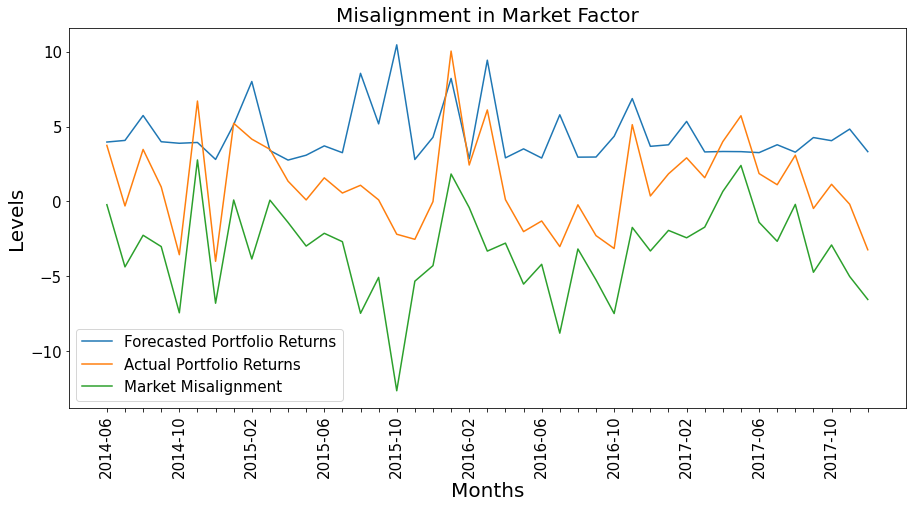

In [ ]:
# mkt_views.plot(y=['forecast','actual','Market View'], figsize=(10,5), grid=True)

plt.figure(figsize = (15, 7))
plt.plot(mkt_views['forecast'], label = "Forecasted Portfolio Returns")
plt.plot(mkt_views['actual'], label = "Actual Portfolio Returns")
plt.plot(mkt_views['Market View'], label = "Market Misalignment")
plt.xticks(rotation = 90)
plt.title("Misalignment in Market Factor", fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Levels", fontsize = 20)
lab = list(mkt_views.index)
lab2 = ['']*len(lab)
lab2[::4] = lab[::4]
plt.xticks(ticks = mkt_views.index, labels = lab2, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

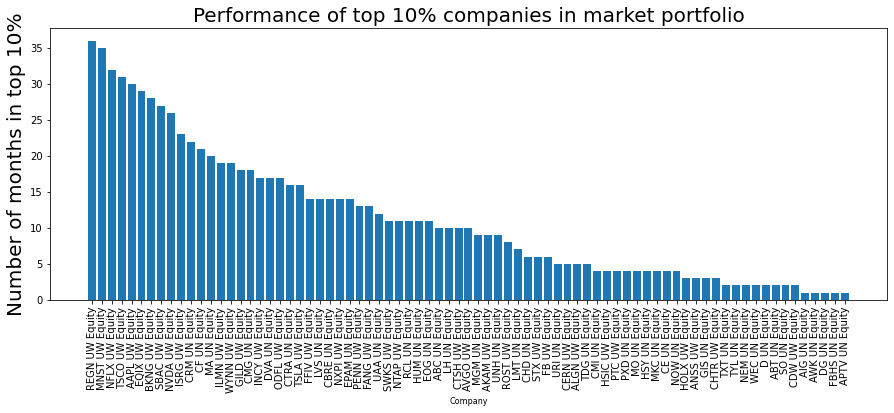

In [ ]:
flat_mkt_top = list(itertools.chain(*mkt_top_portfolios))
dict_mkt_top = dict(Counter(flat_mkt_top))
dict_mkt_top = {k: v for k, v in sorted(dict_mkt_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mkt_top.keys(), dict_mkt_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in market portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 8)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

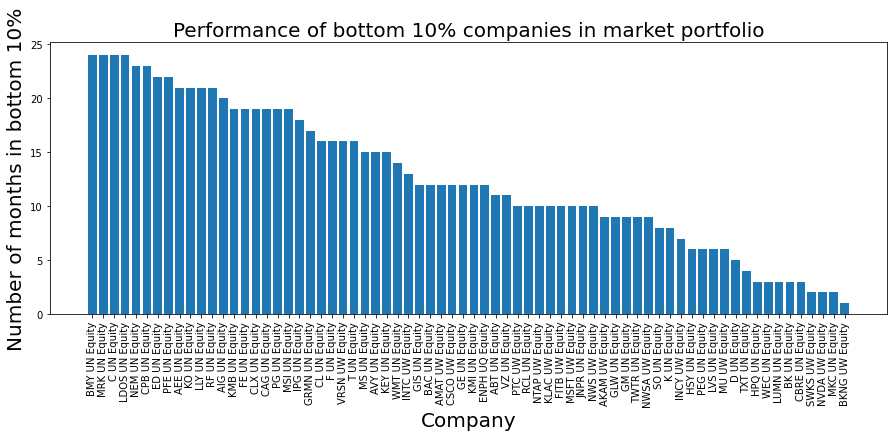

In [ ]:
flat_mkt_bottom = list(itertools.chain(*mkt_bottom_portfolios))
dict_mkt_bottom = dict(Counter(flat_mkt_bottom))
dict_mkt_bottom = {k: v for k, v in sorted(dict_mkt_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mkt_bottom.keys(), dict_mkt_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in market portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

EPAM corresponding sector not found



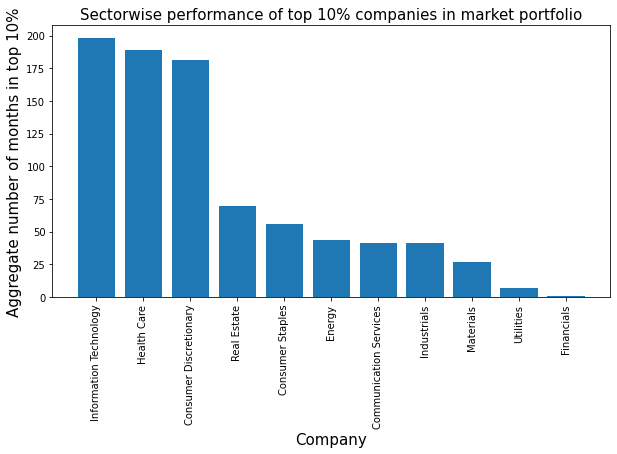

In [ ]:
sector_dict_mkt_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mkt_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mkt_top[company_key_dict[name]] = sector_dict_mkt_top[company_key_dict[name]] + dict_mkt_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mkt_top = {k: v for k, v in sorted(sector_dict_mkt_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mkt_top.keys(), sector_dict_mkt_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in market portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

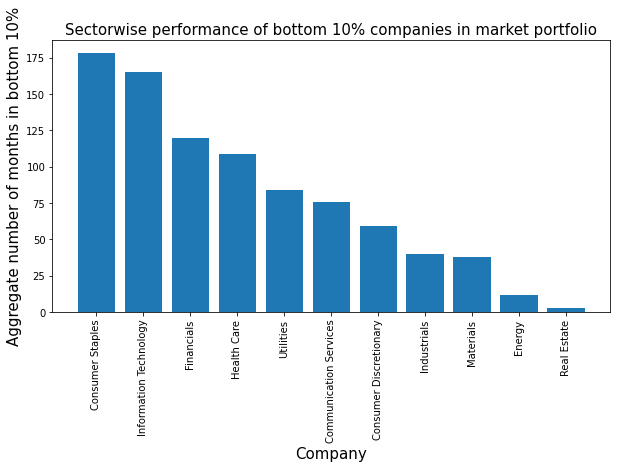

In [ ]:
sector_dict_mkt_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mkt_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mkt_bottom[company_key_dict[name]] = sector_dict_mkt_bottom[company_key_dict[name]] + dict_mkt_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mkt_bottom = {k: v for k, v in sorted(sector_dict_mkt_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mkt_bottom.keys(), sector_dict_mkt_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in market portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Value Factor Forecast

In [ ]:
# VALUE FACTOR forecast

pe_ratio_train_valid = pe_ratio.loc[:'2017-12',]
Y_train_valid = return_.loc[:'2017-12',]
forecast_value = pd.DataFrame(index = pe_ratio_train_valid.index, columns = pe_ratio_train_valid.columns)

cnt_n = 0
cnt_l = 0
cnt = 0

value_param = {}

for column in pe_ratio:
  
  X = pe_ratio_train_valid[column]
  Y = Y_train_valid[column]
  X = X.dropna()
  Y = Y.tail(X.shape[0])
  
  if(X.shape[0] == 0):
    cnt_n = cnt_n + 1
    # print("NO DATA          :", column, X.shape, Y.shape)
  
  elif(X.shape[0] < 45):
    cnt_l = cnt_l + 1
    # print("LESS DATA        :", column, X.index[0], X.index[-1], X.shape, Y.shape)  
  
  else:
    cnt = cnt + 1
    # print("TRAIN/FORECAST   :", column, X.index[0], X.index[-1], X.shape, Y.shape)
    par, pred = forecast(X, Y)
    value_param[column] = par
    forecast_value[column] = pred

print("Number of companies having no data till 2017-12                  :", cnt_n)
print("Number of companies having less than 45 months data till 2017-12 :", cnt_l)
print("Number of companies actually used                                :", cnt)
print()

forecast_value

Number of companies having no data till 2017-12                  : 35
Number of companies having less than 45 months data till 2017-12 : 30
Number of companies actually used                                : 439



,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,SEE UN Equity,CTSH UW Equity,SIVB UW Equity,ISRG UW Equity,TTWO UW Equity,RSG UN Equity,EBAY UW Equity,GS UN Equity,SBAC UW Equity,SRE UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,1.381695,1.424083,0.474277,0.139179,9.206252,0.955425,4.435387,0.363872,-0.943310,0.326612,...,1.066079,1.009073,1.899220,2.461425,2.743349,1.986118,1.042733,-0.327608,NaN,2.639462
2017-09,1.685219,1.446244,0.566050,0.139677,6.900150,0.967963,5.007608,0.370837,-1.065041,0.323041,...,0.955698,1.037535,1.909508,2.782973,2.052526,2.055558,1.047529,-0.273525,NaN,2.626744
2017-10,1.902740,1.453779,0.703375,0.137633,6.934040,0.980754,5.254984,0.507067,-1.111441,0.321811,...,1.094708,1.093525,2.508863,2.796423,2.105970,1.973666,1.045718,0.147530,NaN,2.537766


In [ ]:
forecast_value_final = forecast_value.dropna(axis = 0, how = 'all')
forecast_value_final

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,SEE UN Equity,CTSH UW Equity,SIVB UW Equity,ISRG UW Equity,TTWO UW Equity,RSG UN Equity,EBAY UW Equity,GS UN Equity,SBAC UW Equity,SRE UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2014-06,NaN,NaN,0.820205,0.107613,NaN,0.951904,1.846548,-0.429331,0.674543,0.408442,...,3.785509,1.125421,1.314631,NaN,1.091238,1.310356,0.998100,-1.298524,NaN,2.653513
2014-07,NaN,NaN,0.786295,0.107139,NaN,0.928305,1.816933,-0.390376,0.656287,0.403280,...,3.606916,1.171495,1.259328,NaN,1.094184,1.292926,0.998744,-1.293663,NaN,2.642576
2014-08,NaN,NaN,0.547116,0.116202,NaN,0.898657,1.318234,-0.379227,0.667053,0.424064,...,4.014387,0.956229,0.960669,NaN,1.100483,1.227256,0.999571,-1.302276,NaN,2.904418
2014-09,NaN,NaN,0.599228,0.115018,NaN,0.905699,1.256140,-0.281350,0.685376,0.401829,...,4.469791,0.914549,1.288378,NaN,1.104249,1.243603,0.999109,-1.011417,NaN,3.072829
2014-10,NaN,NaN,0.341501,0.118302,NaN,0.893789,0.727725,-0.355430,0.737506,0.392109,...,3.629301,0.900768,0.915150,NaN,1.101288,1.208376,0.998197,-1.228753,NaN,3.097788
2014-11,NaN,NaN,0.591917,0.117352,NaN,0.897150,0.909709,-0.287607,0.739236,0.380786,...,4.573121,1.123433,1.400662,NaN,1.099909,1.198050,0.998956,-1.197126,NaN,3.101891
2014-12,NaN,NaN,0.668435,0.125750,NaN,0.895537,0.435667,-0.253691,0.776205,0.393366,...,5.385490,1.125760,1.502376,NaN,1.101717,1.233697,0.999783,-1.119194,NaN,3.062966
2015-01,NaN,NaN,0.324333,0.127414,NaN,0.904115,-0.014053,-0.387452,0.787085,0.391062,...,5.387392,1.171974,1.418986,NaN,1.102953,1.271822,0.999358,-1.253873,NaN,3.135313
2015-02,NaN,NaN,-0.060882,0.124084,NaN,0.935210,-0.089175,-0.346610,0.710009,0.405266,...,3.463264,1.296452,2.134999,NaN,1.104473,1.282924,0.999466,-0.966571,NaN,3.016294


In [ ]:
value_views, value_top_portfolios, value_bottom_portfolios = views(forecast_value_final, "Value Views")
value_views

,forecast,actual,Value Views
month_date,,,
2014-06,6.243131,-0.404801,-6.647933
2014-07,6.437854,-0.850199,-7.288053
2014-08,6.781001,1.250172,-5.530829
2014-09,7.031434,2.606501,-4.424933
2014-10,7.226128,4.988891,-2.237237
2014-11,8.157732,5.232021,-2.925711
2014-12,8.713570,2.054228,-6.659343
2015-01,8.884506,4.548855,-4.335652
2015-02,11.770207,2.752655,-9.017552


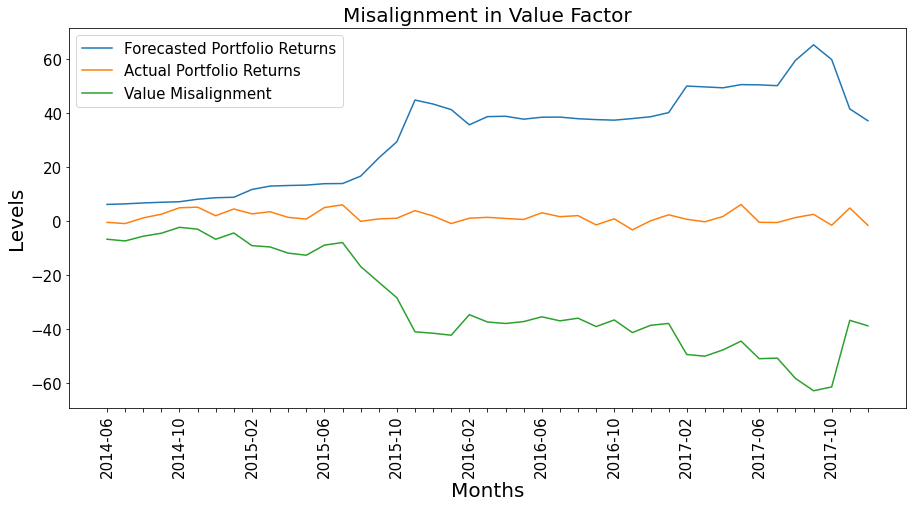

In [ ]:
# value_views.plot(y=['forecast','actual','Value Views'], figsize=(10,5), grid=True)

plt.figure(figsize = (15, 7))
plt.plot(value_views['forecast'], label = "Forecasted Portfolio Returns")
plt.plot(value_views['actual'], label = "Actual Portfolio Returns")
plt.plot(value_views['Value Views'], label = "Value Misalignment")
plt.xticks(rotation = 90)
plt.title("Misalignment in Value Factor", fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Levels", fontsize = 20)
lab = list(value_views.index)
lab2 = ['']*len(lab)
lab2[::4] = lab[::4]
plt.xticks(ticks = value_views.index, labels = lab2, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

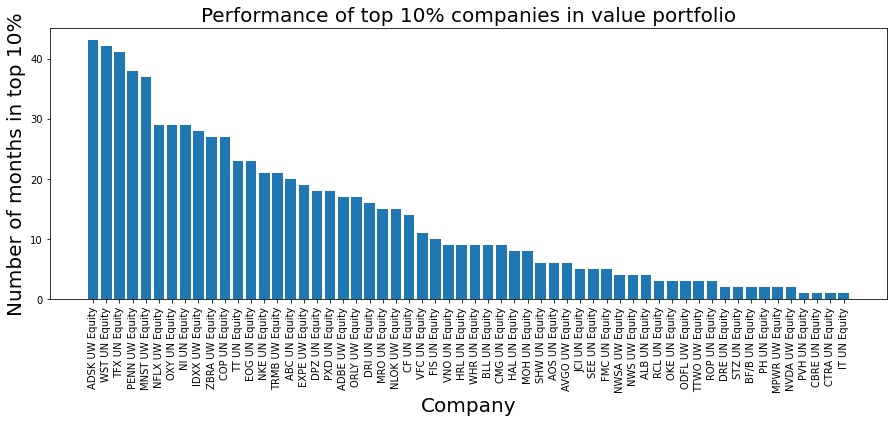

In [ ]:
flat_value_top = list(itertools.chain(*value_top_portfolios))
dict_value_top = dict(Counter(flat_value_top))
dict_value_top = {k: v for k, v in sorted(dict_value_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_value_top.keys(), dict_value_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in value portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

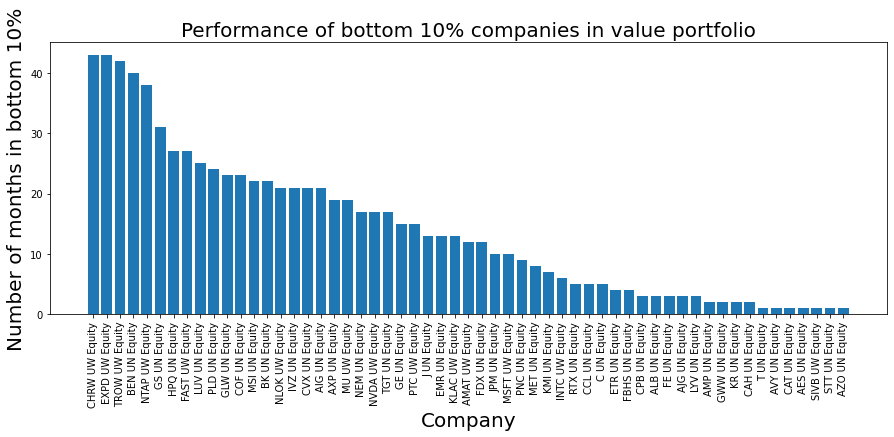

In [ ]:
flat_value_bottom = list(itertools.chain(*value_bottom_portfolios))
dict_value_bottom = dict(Counter(flat_value_bottom))
dict_value_bottom = {k: v for k, v in sorted(dict_value_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_value_bottom.keys(), dict_value_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in value portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

MOH corresponding sector not found
BF/B corresponding sector not found



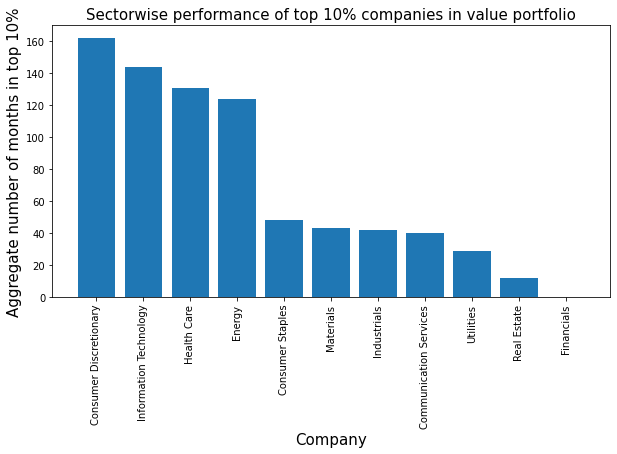

In [ ]:
sector_dict_value_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_value_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_value_top[company_key_dict[name]] = sector_dict_value_top[company_key_dict[name]] + dict_value_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_value_top = {k: v for k, v in sorted(sector_dict_value_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_value_top.keys(), sector_dict_value_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in value portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

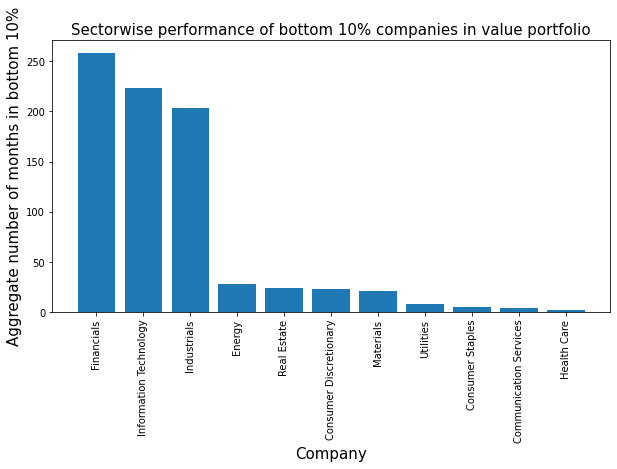

In [ ]:
sector_dict_value_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_value_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_value_bottom[company_key_dict[name]] = sector_dict_value_bottom[company_key_dict[name]] + dict_value_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_value_bottom = {k: v for k, v in sorted(sector_dict_value_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_value_bottom.keys(), sector_dict_value_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in value portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Size Factor Forecast

In [ ]:
# SIZE FACTOR forecast

mcap_train_valid = mcap.loc[:'2017-12',]
Y_train_valid = return_.loc[:'2017-12',]
forecast_size = pd.DataFrame(index = mcap_train_valid.index, columns = mcap_train_valid.columns)

cnt_n = 0
cnt_l = 0
cnt = 0

size_param = {}

for column in mcap:
  
  X = mcap_train_valid[column]
  Y = Y_train_valid[column]
  X = X.dropna()
  Y = Y.tail(X.shape[0])
  
  if(X.shape[0] == 0):
    cnt_n = cnt_n + 1
    # print("NO DATA          :", column, X.shape, Y.shape)
  
  elif(X.shape[0] < 45):
    cnt_l = cnt_l + 1
    # print("LESS DATA        :", column, X.index[0], X.index[-1], X.shape, Y.shape)  
  
  else:
    cnt = cnt + 1
    # print("TRAIN/FORECAST   :", column, X.index[0], X.index[-1], X.shape, Y.shape)
    par, pred = forecast(X, Y)
    size_param[column] = par
    forecast_size[column] = pred

print("Number of companies having no data till 2017-12                  :", cnt_n)
print("Number of companies having less than 45 months data till 2017-12 :", cnt_l)
print("Number of companies actually used                                :", cnt)
print()

forecast_size

Number of companies having no data till 2017-12                  : 21
Number of companies having less than 45 months data till 2017-12 : 26
Number of companies actually used                                : 457



,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,NaN,NaN,1.586668,2.603200,NaN,5.813696,1.959325,4.202318,1.236141,1.823981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,NaN,NaN,1.666676,2.577972,NaN,6.133014,2.067988,4.216202,1.320320,1.846361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10,NaN,NaN,1.913612,2.660526,NaN,6.549541,2.215726,4.636683,1.377498,1.856167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
forecast_size_final = forecast_size.dropna(axis = 0, how = 'all')
forecast_size_final

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2014-06,NaN,NaN,2.936365,2.808524,NaN,3.438956,1.946873,2.074381,1.537833,1.505132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,NaN,NaN,2.886121,2.938213,NaN,3.171390,1.963499,2.106113,1.588071,1.547177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,NaN,NaN,2.485909,2.784995,NaN,3.019447,1.922730,2.077069,1.528994,1.416409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,NaN,NaN,2.540293,2.836341,NaN,3.160029,1.905353,2.279976,1.479362,1.562623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,NaN,NaN,2.342386,2.772490,NaN,2.980054,1.774129,2.150236,1.338970,1.633546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,NaN,NaN,2.626114,2.962560,NaN,3.178027,1.814245,2.284263,1.355455,1.699610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,NaN,NaN,2.707426,2.584128,NaN,3.144569,1.681101,2.352981,1.252441,1.616918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,NaN,NaN,2.394184,2.541433,NaN,3.328023,1.552281,2.057583,1.211778,1.632062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,NaN,NaN,2.064846,2.764368,NaN,3.965825,1.521909,2.131503,1.241820,1.561074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
size_views, size_top_portfolios, size_bottom_portfolios = views(forecast_size_final, "Size Views")
size_views

,forecast,actual,Size Views
month_date,,,
2014-06,6.647821,0.247825,-6.399996
2014-07,6.816639,1.799932,-5.016707
2014-08,6.947759,1.758283,-5.189476
2014-09,7.140987,0.851593,-6.289394
2014-10,6.889598,1.868656,-5.020941
2014-11,8.128796,8.505882,0.377086
2014-12,8.630636,2.928692,-5.701944
2015-01,8.993909,1.894295,-7.099614
2015-02,10.065262,5.279127,-4.786135


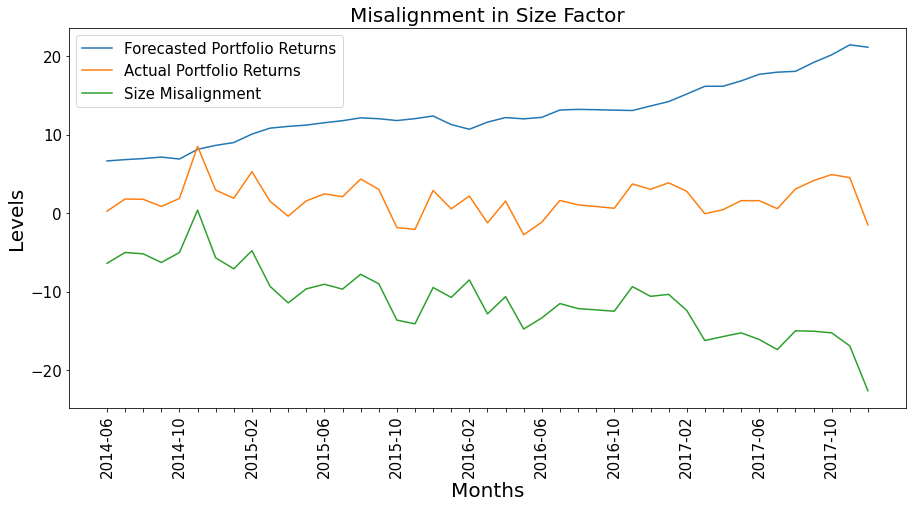

In [ ]:
# size_views.plot(y=['forecast','actual','Size Views'], figsize=(10,5), grid=True)

plt.figure(figsize = (15, 7))
plt.plot(size_views['forecast'], label = "Forecasted Portfolio Returns")
plt.plot(size_views['actual'], label = "Actual Portfolio Returns")
plt.plot(size_views['Size Views'], label = "Size Misalignment")
plt.xticks(rotation = 90)
plt.title("Misalignment in Size Factor", fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Levels", fontsize = 20)
lab = list(size_views.index)
lab2 = ['']*len(lab)
lab2[::4] = lab[::4]
plt.xticks(ticks = size_views.index, labels = lab2, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

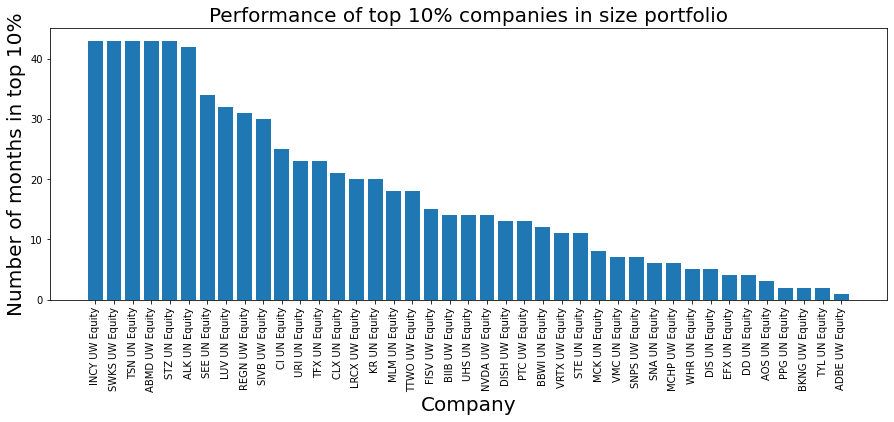

In [ ]:
flat_size_top = list(itertools.chain(*size_top_portfolios))
dict_size_top = dict(Counter(flat_size_top))
dict_size_top = {k: v for k, v in sorted(dict_size_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_size_top.keys(), dict_size_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in size portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

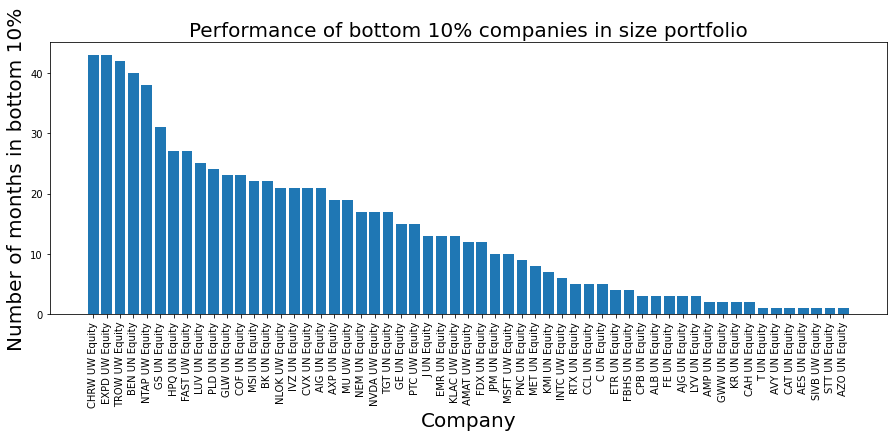

In [ ]:
flat_size_bottom = list(itertools.chain(*size_bottom_portfolios))
dict_size_bottom = dict(Counter(flat_value_bottom))
dict_size_bottom = {k: v for k, v in sorted(dict_size_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_size_bottom.keys(), dict_size_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in size portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

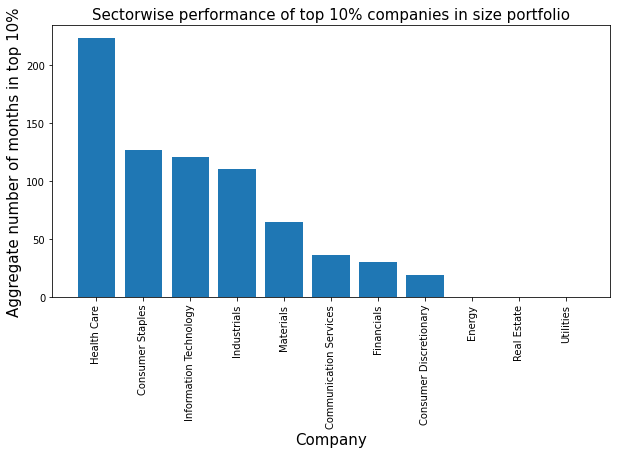

In [ ]:
sector_dict_size_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_size_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_size_top[company_key_dict[name]] = sector_dict_size_top[company_key_dict[name]] + dict_size_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_size_top = {k: v for k, v in sorted(sector_dict_size_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_size_top.keys(), sector_dict_size_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in size portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

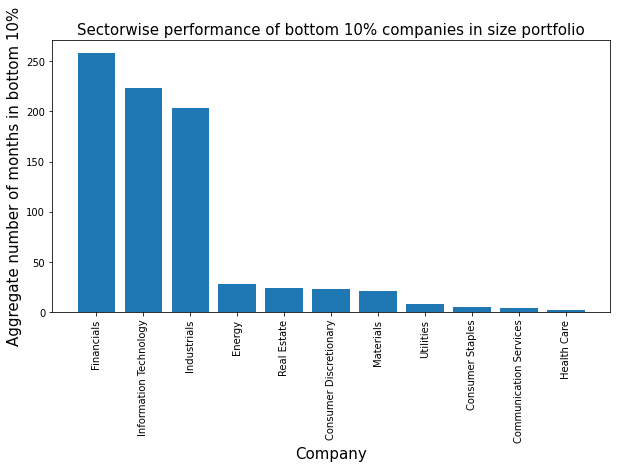

In [ ]:
sector_dict_size_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_size_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_size_bottom[company_key_dict[name]] = sector_dict_size_bottom[company_key_dict[name]] + dict_size_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_size_bottom = {k: v for k, v in sorted(sector_dict_size_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_size_bottom.keys(), sector_dict_size_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in size portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Momentum Factor Forecast

In [ ]:
# MOMENTUM FACTOR forecast

forecast_mom = pd.DataFrame(index = return_[:'2018-01'].index, columns = return_.columns)

count = 0
mom_param = {}
for col in mom_fac.columns:
  X = pd.DataFrame(mom_fac[:'2018-01'][col].dropna())
  if len(X) > 45:
    X['Lag_2'], X['Lag_3'],X['Lag_4'], X['Lag_5'],X['Lag_6'], X['Lag_7'],X['Lag_8'], X['Lag_9'],X['Lag_10'], X['Lag_11'],X['Lag_12'] = X.shift(2), X.shift(3),X.shift(4), X.shift(5),X.shift(6), X.shift(7),X.shift(8), X.shift(9),X.shift(10), X.shift(11), X.shift(12)
    X = X.iloc[12:]
    X = X.drop(col,1)
    Y = return_[:'2018-01'][col].tail(X.shape[0])
    par, pred = forecast(X,Y)
    mom_param[col] = par
    forecast_mom[col] = pred

forecast_mom

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09,3.265064,7.358136,-4.022349,-1.912159,3.136667,-1.992603,2.077252,-15.748710,-0.196451,0.618796,...,10.669739,-19.827028,16.992850,1.411825,3.677555,1.116685,-3.077173,-1.048157,-1.665623,-4.225217
2017-10,-1.549557,7.622888,1.691186,-3.743963,-6.784785,-0.198593,-1.051895,-9.305303,0.292145,0.504314,...,13.891921,-1.922017,15.147912,0.928670,2.060017,4.240152,-7.954089,-5.684827,-1.348895,1.910448
2017-11,-0.103963,6.026641,0.669838,-0.704360,7.998999,-2.118947,-2.253549,-8.579650,1.371938,-0.173538,...,22.515375,-21.006793,0.740238,0.648240,0.473082,-0.984298,-8.904678,-9.414150,-6.570086,3.861351


In [ ]:
forecast_mom_final = forecast_mom.dropna(axis = 0, how = 'all')
forecast_mom_final

,LYB UN Equity,SBNY UW Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,...,AAP UN Equity,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,ZTS UN Equity,DLR UN Equity,EQIX UW Equity,MOH UN Equity,LVS UN Equity
month_date,,,,,,,,,,,,,,,,,,,,,
2014-09,NaN,NaN,-6.494111,-3.314043,NaN,-6.764334,-0.630083,-5.616183,-1.784302,0.325007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,NaN,NaN,1.052522,-0.808261,NaN,-5.200566,-2.704493,-3.209444,1.361015,0.213720,...,NaN,NaN,16.639231,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,NaN,NaN,-2.046531,-1.580889,NaN,-6.480705,-1.398283,-1.912281,1.320631,0.730963,...,NaN,-4.536379,-2.039625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,NaN,NaN,-11.628018,0.689266,NaN,-1.029353,-2.756366,-5.653304,1.987872,0.114248,...,NaN,-8.784164,-17.935161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,NaN,NaN,-3.768165,-1.560335,NaN,-0.881183,-1.752402,-3.274664,-1.678734,0.197769,...,4.577643,-7.706332,1.037454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,NaN,NaN,5.883008,1.490086,NaN,-2.539532,-0.661563,-2.626659,1.919498,-0.848801,...,3.557664,-6.447015,10.838125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,NaN,NaN,-8.424989,-3.102340,NaN,-5.158741,2.211543,-5.784291,-0.351155,-0.659653,...,1.671981,-5.962219,9.845171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,NaN,NaN,-4.363969,-0.969173,NaN,-1.867643,0.163627,-2.816624,1.217092,0.021944,...,0.814413,2.193865,0.101284,NaN,NaN,NaN,NaN,4.741525,NaN,NaN
2015-05,NaN,NaN,-6.096195,-2.381400,NaN,-2.515453,-3.690459,-3.604020,-0.594498,-0.158476,...,4.408364,-12.910472,-9.184995,NaN,NaN,NaN,NaN,-3.878051,2.274080,NaN


In [ ]:
mom_views, mom_top_portfolios, mom_bottom_portfolios = views(forecast_mom_final, "Momentum Views")
mom_views

,forecast,actual,Momentum Views
month_date,,,
2014-09,12.659868,-1.649493,-14.309361
2014-10,16.993965,0.018909,-16.975056
2014-11,15.881305,-3.348681,-19.229986
2014-12,15.773250,0.583535,-15.189715
2015-01,17.028190,-1.276464,-18.304654
2015-02,19.659686,-2.682220,-22.341906
2015-03,18.759809,-2.708680,-21.468489
2015-04,18.957690,2.447254,-16.510436
2015-05,18.975795,3.848698,-15.127097


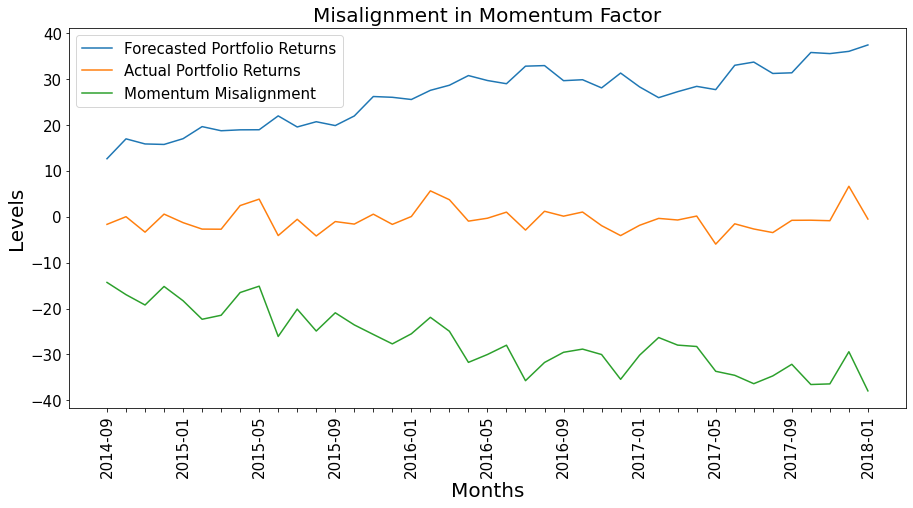

In [ ]:
# mom_views.plot(y=['forecast','actual','Momentum Views'], figsize=(10,5), grid=True)

plt.figure(figsize = (15, 7))
plt.plot(mom_views['forecast'], label = "Forecasted Portfolio Returns")
plt.plot(mom_views['actual'], label = "Actual Portfolio Returns")
plt.plot(mom_views['Momentum Views'], label = "Momentum Misalignment")
plt.xticks(rotation = 90)
plt.title("Misalignment in Momentum Factor", fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Levels", fontsize = 20)
lab = list(mom_views.index)
lab2 = ['']*len(lab)
lab2[::4] = lab[::4]
plt.xticks(ticks = mom_views.index, labels = lab2, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

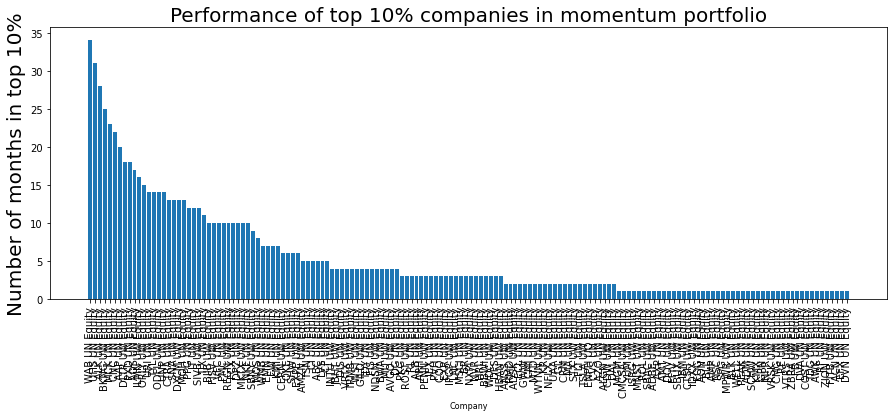

In [ ]:
flat_mom_top = list(itertools.chain(*mom_top_portfolios))
dict_mom_top = dict(Counter(flat_mom_top))
dict_mom_top = {k: v for k, v in sorted(dict_mom_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mom_top.keys(), dict_mom_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in momentum portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 8)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

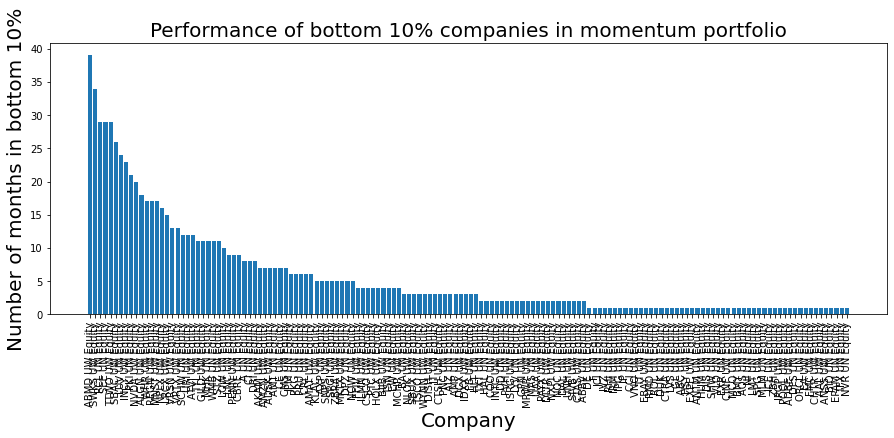

In [ ]:
flat_mom_bottom = list(itertools.chain(*mom_bottom_portfolios))
dict_mom_bottom = dict(Counter(flat_mom_bottom))
dict_mom_bottom = {k: v for k, v in sorted(dict_mom_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mom_bottom.keys(), dict_mom_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in momentum portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

MOH corresponding sector not found
SBNY corresponding sector not found
NDSN corresponding sector not found



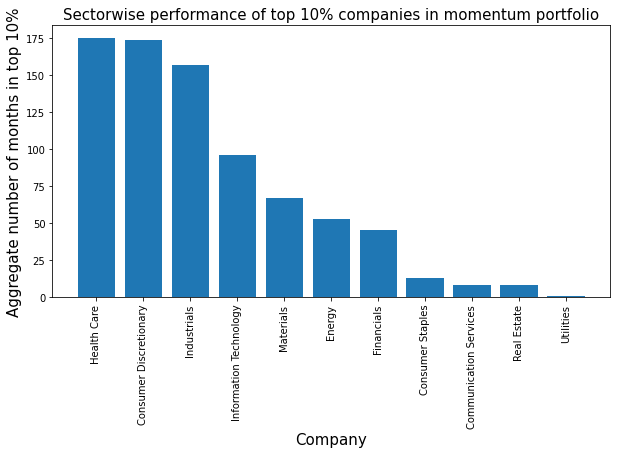

In [ ]:
sector_dict_mom_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mom_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mom_top[company_key_dict[name]] = sector_dict_mom_top[company_key_dict[name]] + dict_mom_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mom_top = {k: v for k, v in sorted(sector_dict_mom_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mom_top.keys(), sector_dict_mom_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in momentum portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

EPAM corresponding sector not found



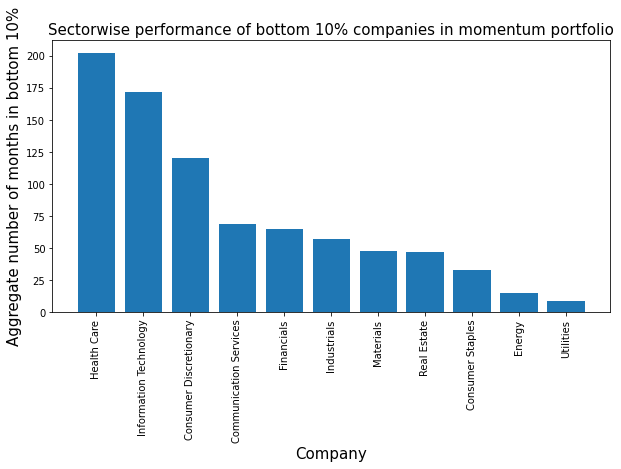

In [ ]:
sector_dict_mom_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mom_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mom_bottom[company_key_dict[name]] = sector_dict_mom_bottom[company_key_dict[name]] + dict_mom_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mom_bottom = {k: v for k, v in sorted(sector_dict_mom_bottom.items(), key=lambda item: item[1], reverse = True)}

print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mom_bottom.keys(), sector_dict_mom_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in momentum portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

# **POLYNOMIAL REGRESSION**

Market views
MSE for Polynomial fit: 7.191176720781105
MSE for Exponential fit: 10.95614298004246
MSE for Sinusoidal fit: 51.273696520702806
Polynomial model chosen
Optimal degree of using polynomial : 2


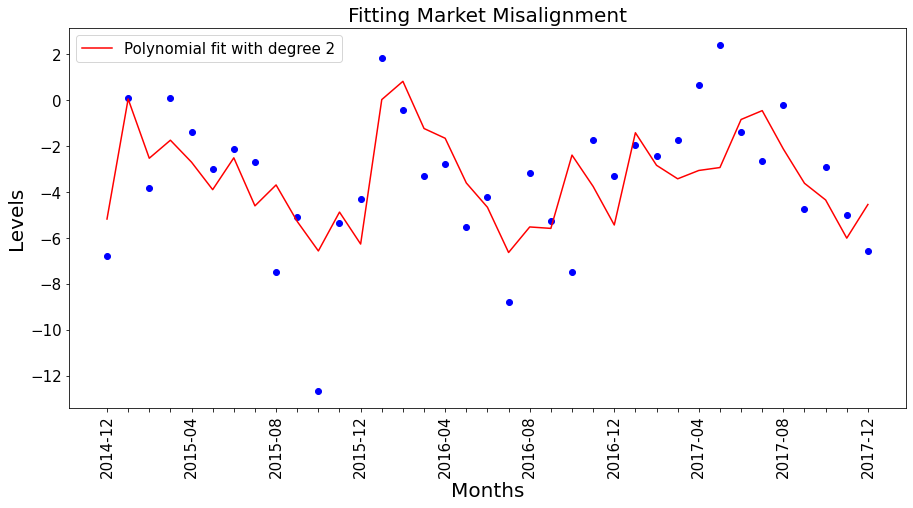

In [ ]:
mkt_view_lag = Diff_Lag(mkt_views)
degrees = np.arange(1, 10)
print('Market views')
mkt_deg, mkt_transform_type, mkt_model_coef, mkt_model_intercept = scratch_transformed(mkt_view_lag, degrees)

Value views
MSE for Polynomial fit: 89.18236823501314
MSE for Exponential fit: 81.76302540975792
MSE for Sinusoidal fit: 107.0487395599148
Exponential model chosen


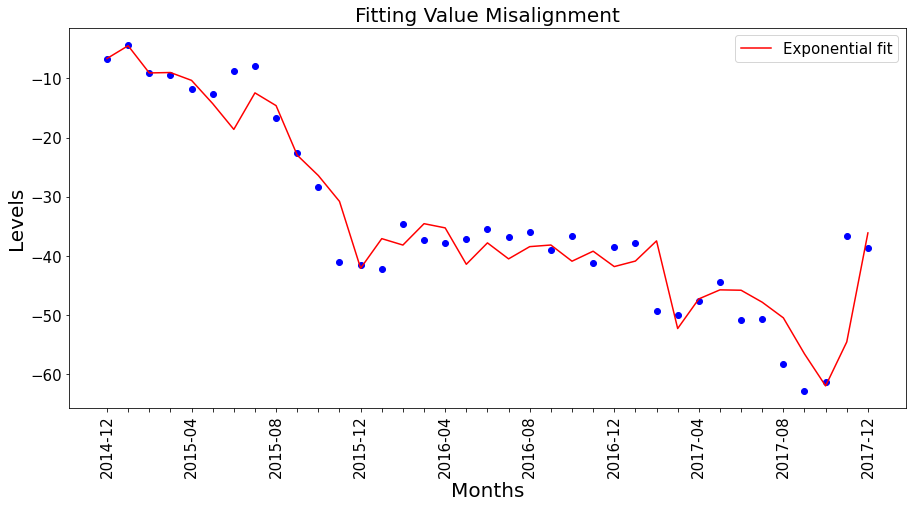

In [ ]:
value_view_lag = Diff_Lag(value_views)
degrees = np.arange(1, 10)
print('Value views')
value_deg, value_transform_type, value_model_coef, value_model_intercept = scratch_transformed(value_view_lag, degrees)

Size views
MSE for Polynomial fit: 11.278606558321782
MSE for Exponential fit: 19.38413270267402
MSE for Sinusoidal fit: 11.64358270009523
Polynomial model chosen
Optimal degree of using polynomial : 1


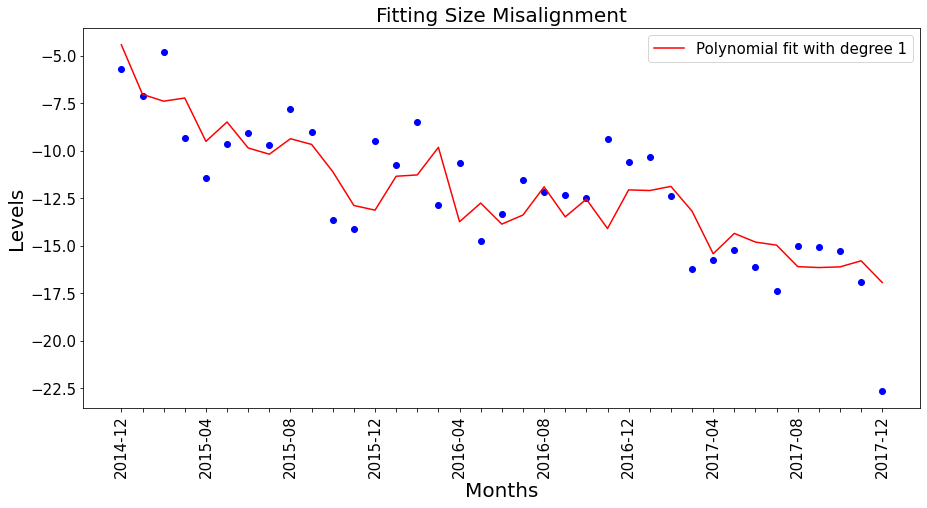

In [ ]:
size_view_lag = Diff_Lag(size_views)
degrees = np.arange(1, 10)
print('Size views')
size_deg, size_transform_type, size_model_coef, size_model_intercept = scratch_transformed(size_view_lag, degrees)

Momentum views
MSE for Polynomial fit: 17.702827368818173
MSE for Exponential fit: 20.777484442939908
MSE for Sinusoidal fit: 18.447097380014245
Polynomial model chosen
Optimal degree of using polynomial : 1


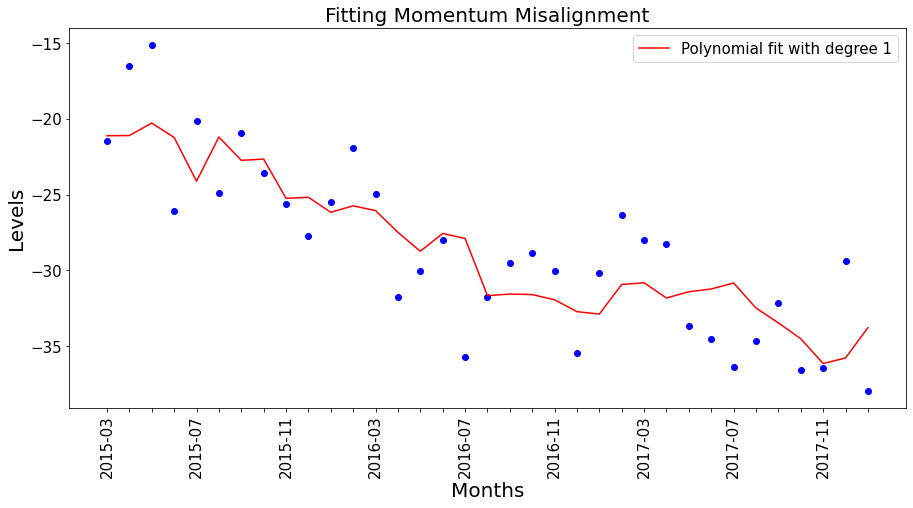

In [ ]:
mom_view_lag = Diff_Lag(mom_views)
degrees = np.arange(1, 10)
print('Momentum views')
mom_deg, mom_transform_type, mom_model_coef, mom_model_intercept = scratch_transformed(mom_view_lag, degrees)

# **FORECASTING**

In [ ]:
# Forecasting returns in test time frame

mkt_test = mkt.loc['2018-01':,]
mkt_test_forecast = pd.DataFrame(index = mkt_test.index, columns = return_.columns)
for col in mkt_test_forecast:
  if col in mkt_param:
    mkt_test_forecast[col] = mkt_param[col][0] + mkt_param[col][1]*mkt_test["Mkt-RF"]

pe_ratio_test = pe_ratio.loc['2018-01':,]
value_test_forecast = pd.DataFrame(index = pe_ratio_test.index, columns = pe_ratio_test.columns)
for col in value_test_forecast:
  if col in value_param:
    value_test_forecast[col] = value_param[col][0] + value_param[col][1]*pe_ratio_test[col]

mcap_test = mcap.loc['2018-01':,]
size_test_forecast = pd.DataFrame(index = mcap_test.index, columns = mcap_test.columns)
for col in size_test_forecast:
  if col in size_param:
    size_test_forecast[col] = size_param[col][0] + size_param[col][1]*mcap_test[col]

mom_test = return_.loc['2017-01':,]
mom_test_forecast = pd.DataFrame(index = mom_test.index, columns = mom_test.columns)
for col in mom_test_forecast:
    if col in mom_param:
      mom_test_forecast[col] = mom_param[col][0] + mom_param[col][1]*mom_test[col].shift(2)+mom_param[col][2]*mom_test[col].shift(3)+mom_param[col][3]*mom_test[col].shift(4)+mom_param[col][4]*mom_test[col].shift(5)+mom_param[col][5]*mom_test[col].shift(6)+mom_param[col][6]*mom_test[col].shift(7)+mom_param[col][7]*mom_test[col].shift(8)+mom_param[col][8]*mom_test[col].shift(9)+mom_param[col][9]*mom_test[col].shift(10)+mom_param[col][10]*mom_test[col].shift(11)+mom_param[col][11]*mom_test[col].shift(12)
mom_test_forecast = mom_test_forecast.loc['2018-01':,]

In [ ]:
mkt_diff_df=forecast_diff(mkt_views,mkt_deg, mkt_transform_type, mkt_model_coef, mkt_model_intercept)
mkt_diff_df['Date']=np.append('2017-06',mkt_test.index)
mkt_diff_df.set_index('Date',inplace=True)
mkt_diff_forecast=mkt_diff_df.loc['2018-01':,'Lag_1']

In [ ]:
value_diff_df=forecast_diff(value_views,value_deg, value_transform_type, value_model_coef, value_model_intercept)
value_diff_df['Date']=np.append('2017-06',mkt_test.index)
value_diff_df.set_index('Date',inplace=True)
value_diff_forecast=value_diff_df.loc['2018-01':,'Lag_1']

In [ ]:
size_diff_df=forecast_diff(size_views,size_deg, size_transform_type, size_model_coef, size_model_intercept)
size_diff_df['Date']=np.append('2017-06',mkt_test.index)
size_diff_df.set_index('Date',inplace=True)
size_diff_forecast=size_diff_df.loc['2018-01':,'Lag_1']

In [ ]:
mom_diff_df=forecast_diff(mom_views,mom_deg, mom_transform_type, mom_model_coef, mom_model_intercept)
date=['2017-11','2017-12']
mom_diff_df['Date']=np.append(date,mkt_test.index)
mom_diff_df.set_index('Date',inplace=True)
mom_diff_forecast=mom_diff_df.loc['2018-01':,'Lag_1']

In [ ]:
mkt_top, mkt_bottom, mkt_view = adj_views(mkt_test_forecast, mkt_diff_forecast)
value_top, value_bottom, value_view = adj_views(value_test_forecast, value_diff_forecast)
size_top, size_bottom, size_view = adj_views(size_test_forecast, size_diff_forecast)
mom_top, mom_bottom, mom_view = adj_views(mom_test_forecast, mom_diff_forecast)

In [ ]:
# Forecasting returns in train-valid time frame

mkt_train = mkt.loc[:'2017-12',]
mkt_train_forecast = pd.DataFrame(index = mkt_train.index, columns = return_.columns)
for col in mkt_train_forecast:
  if col in mkt_param:
    mkt_train_forecast[col] = mkt_param[col][0] + mkt_param[col][1]*mkt_train["Mkt-RF"]

pe_ratio_train = pe_ratio.loc[:'2017-12',]
value_train_forecast = pd.DataFrame(index = pe_ratio_train.index, columns = pe_ratio_train.columns)
for col in value_train_forecast:
  if col in value_param:
    value_train_forecast[col] = value_param[col][0] + value_param[col][1]*pe_ratio_train[col]

mcap_train = mcap.loc[:'2017-12',]
size_train_forecast = pd.DataFrame(index = mcap_train.index, columns = mcap_train.columns)
for col in size_train_forecast:
  if col in size_param:
    size_train_forecast[col] = size_param[col][0] + size_param[col][1]*mcap_train[col]

mom_train = return_.loc[:'2017-12',]
mom_train_forecast = pd.DataFrame(index = mom_train.index, columns = mom_train.columns)
for col in mom_train_forecast:
    if col in mom_param:
      mom_train_forecast[col] = mom_param[col][0] + mom_param[col][1]*mom_train[col].shift(2)+mom_param[col][2]*mom_train[col].shift(3)+mom_param[col][3]*mom_train[col].shift(4)+mom_param[col][4]*mom_train[col].shift(5)+mom_param[col][5]*mom_train[col].shift(6)+mom_param[col][6]*mom_train[col].shift(7)+mom_param[col][7]*mom_train[col].shift(8)+mom_param[col][8]*mom_train[col].shift(9)+mom_param[col][9]*mom_train[col].shift(10)+mom_param[col][10]*mom_train[col].shift(11)+mom_param[col][11]*mom_train[col].shift(12)

# **BLACK LITTERMAN AND MARKOVITZ**

In [ ]:
test_time_frame = return_.loc['2018-01':'2019-01'].index
index = -1
our_returns = []

for t in test_time_frame:

  if(t > '2018-12'):
    break
  
  index = index + 1

  # 4*4 Cov Matrix
  mkt_1 = train_forecast(mkt_train_forecast, mkt_top[index], mkt_bottom[index], "new_forecast")
  mkt_2 = pd.DataFrame(mkt_view.loc[:t]["new_forecast"])
  mkt_port = mkt_1.append(mkt_2)
  value_1 = train_forecast(value_train_forecast, value_top[index], value_bottom[index], "new_forecast")
  value_2 = pd.DataFrame(value_view.loc[:t]["new_forecast"])
  value_port = value_1.append(value_2)
  size_1 = train_forecast(size_train_forecast, size_top[index], size_bottom[index], "new_forecast")
  size_2 = pd.DataFrame(size_view.loc[:t]["new_forecast"])
  size_port = size_1.append(size_2)
  mom_1 = train_forecast(mom_train_forecast, mom_top[index], mom_bottom[index], "new_forecast")
  mom_2 = pd.DataFrame(mom_view.loc[:t]["new_forecast"])
  mom_port = mom_1.append(mom_2)
  temp1 = mkt_port.join(value_port, on='month_date', lsuffix = '_mkt', rsuffix='_value')
  temp2 = temp1.join(size_port, on='month_date', rsuffix='_size')
  port_f = temp2.join(mom_port, on='month_date', rsuffix='_mom')
  port_f = port_f.fillna(0) 
  port_f = port_f.rename(columns={'new_forecast': 'new_forecast_size'})
  sigma_f = port_f.cov()
  
  # Q is 4*1 view list
  views = np.array([mkt_view.loc[t]["new_forecast"], value_view.loc[t]["new_forecast"], 
           size_view.loc[t]["new_forecast"],mom_view.loc[t]["new_forecast"]])

  # P is picking matrix 4*N
  P = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

  rets, cov = BL(sigma_f, views, P)
  weights = Markowitz(cov, 4)


  #calculate portfolio return
  mkt_long, mkt_short = calc_return(mkt_top,mkt_bottom,index,test_time_frame[int(index+1)])
  mkt_long_weighted = [element * weights[0]/(len(mkt_long)*2) for element in mkt_long]
  mkt_short_weighted = [element * weights[0]/(len(mkt_short)*2) for element in mkt_short]
  mkt_port = sum(mkt_long_weighted) - sum(mkt_short_weighted)

  value_long, value_short = calc_return(value_top,value_bottom,index,test_time_frame[int(index+1)])
  value_long_weighted = [element * weights[1]/(len(value_long)*2) for element in value_long]
  value_short_weighted = [element * weights[1]/(len(value_short)*2) for element in value_short]
  value_port = sum(value_long_weighted) - sum(value_short_weighted)

  size_long, size_short = calc_return(size_top,size_bottom,index,test_time_frame[int(index+1)])
  size_long_weighted = [element * weights[2]/(len(size_long)*2) for element in size_long]
  size_short_weighted = [element * weights[2]/(len(size_short)*2) for element in size_short]
  size_port = sum(size_long_weighted) - sum(size_short_weighted)

  mom_long, mom_short = calc_return(mom_top,mom_bottom,index,test_time_frame[int(index+1)])
  mom_long_weighted = [element * weights[3]/(len(mom_long)*2) for element in mom_long]
  mom_short_weighted = [element * weights[3]/(len(mom_short)*2) for element in mom_short]
  mom_port = sum(mom_long_weighted) - sum(mom_short_weighted)
  
  total_ret = mkt_port + value_port + size_port + mom_port
  our_returns.append(total_ret)

  print("Time instance:", t)
  print("Weight on market:", weights[0], "Return on market:", mkt_port)
  print("Weight on value:", weights[1], "Return on value:", value_port)
  print("Weight on size:", weights[2], "Return on size:", size_port)
  print("Weight on momemntum:", weights[3], "Return on momentum:", mom_port)
  print("weighted portfolio return:",total_ret)
  print()

Time instance: 2018-01
Weight on market: 0.23180013421116327 Return on market: 0.2552579991748023
Weight on value: -0.3276753573956085 Return on value: 0.06264367954361949
Weight on size: 0.8112871718234934 Return on size: -0.12368694875658237
Weight on momemntum: 0.2845880513609521 Return on momentum: -0.413856316741242
weighted portfolio return: -0.2196415867794026

Time instance: 2018-02
Weight on market: 0.3514615892534581 Return on market: -1.3105601247232301
Weight on value: -0.28665413389472255 Return on value: 0.11666417007308852
Weight on size: 0.7666851371395869 Return on size: 1.527212649668224
Weight on momemntum: 0.1685074075016775 Return on momentum: 0.06717896609822813
weighted portfolio return: 0.4004956611163105

Time instance: 2018-03
Weight on market: 0.45557329088020193 Return on market: 0.3662605388651608
Weight on value: -0.22020026758228464 Return on value: -0.30264339647717897
Weight on size: 0.6462061518439531 Return on size: -0.5885911914492286
Weight on momem

In [ ]:
df_our_returns=pd.DataFrame(our_returns, index=test_time_frame[:len(test_time_frame)-1], columns = ["Returns"])
cum_return=np.cumprod(1+df_our_returns)
print("Cumulative returns using our strategy:", round((cum_return.loc["2018-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using our strategy: -100.5153 %


**Note: Returns being negative tell us to hypertune weights obtained from Markowitz excatly negative of what obtained so as to achieve a net postive return.**

In [ ]:
final_time_frame = return_.loc['2019-01':'2020-01'].index
index = -1
final_returns = []

mkt_weights = []
value_weights = []
size_weights = []
mom_weights = []

for t in final_time_frame:

  if(t > '2019-12'):
    break
  
  index = index + 1

  # 4*4 Cov Matrix
  mkt_1 = train_forecast(mkt_train_forecast, mkt_top[index], mkt_bottom[index], "new_forecast")
  mkt_2 = pd.DataFrame(mkt_view.loc[:t]["new_forecast"])
  mkt_port = mkt_1.append(mkt_2)
  value_1 = train_forecast(value_train_forecast, value_top[index], value_bottom[index], "new_forecast")
  value_2 = pd.DataFrame(value_view.loc[:t]["new_forecast"])
  value_port = value_1.append(value_2)
  size_1 = train_forecast(size_train_forecast, size_top[index], size_bottom[index], "new_forecast")
  size_2 = pd.DataFrame(size_view.loc[:t]["new_forecast"])
  size_port = size_1.append(size_2)
  mom_1 = train_forecast(mom_train_forecast, mom_top[index], mom_bottom[index], "new_forecast")
  mom_2 = pd.DataFrame(mom_view.loc[:t]["new_forecast"])
  mom_port = mom_1.append(mom_2)
  temp1 = mkt_port.join(value_port, on='month_date', lsuffix = '_mkt', rsuffix='_value')
  temp2 = temp1.join(size_port, on='month_date', rsuffix='_size')
  port_f = temp2.join(mom_port, on='month_date', rsuffix='_mom')
  port_f = port_f.fillna(0) 
  port_f = port_f.rename(columns={'new_forecast': 'new_forecast_size'})
  sigma_f = port_f.cov()
  
  # Q is 4*1 view list
  views = np.array([mkt_view.loc[t]["new_forecast"], value_view.loc[t]["new_forecast"], 
           size_view.loc[t]["new_forecast"],mom_view.loc[t]["new_forecast"]])

  # P is picking matrix 4*N
  P = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

  rets, cov = BL(sigma_f, views, P)
  weights = Markowitz(cov, 4)
  weights = -1 * weights 


  #calculate portfolio return
  mkt_long, mkt_short = calc_return(mkt_top,mkt_bottom,index,test_time_frame[int(index+1)])
  mkt_long_weighted = [element * weights[0]/(len(mkt_long)*2) for element in mkt_long]
  mkt_short_weighted = [element * weights[0]/(len(mkt_short)*2) for element in mkt_short]
  mkt_port = sum(mkt_long_weighted) - sum(mkt_short_weighted)

  value_long, value_short = calc_return(value_top,value_bottom,index,test_time_frame[int(index+1)])
  value_long_weighted = [element * weights[1]/(len(value_long)*2) for element in value_long]
  value_short_weighted = [element * weights[1]/(len(value_short)*2) for element in value_short]
  value_port = sum(value_long_weighted) - sum(value_short_weighted)

  size_long, size_short = calc_return(size_top,size_bottom,index,test_time_frame[int(index+1)])
  size_long_weighted = [element * weights[2]/(len(size_long)*2) for element in size_long]
  size_short_weighted = [element * weights[2]/(len(size_short)*2) for element in size_short]
  size_port = sum(size_long_weighted) - sum(size_short_weighted)

  mom_long, mom_short = calc_return(mom_top,mom_bottom,index,test_time_frame[int(index+1)])
  mom_long_weighted = [element * weights[3]/(len(mom_long)*2) for element in mom_long]
  mom_short_weighted = [element * weights[3]/(len(mom_short)*2) for element in mom_short]
  mom_port = sum(mom_long_weighted) - sum(mom_short_weighted)
  
  total_ret = mkt_port + value_port + size_port + mom_port
  final_returns.append(total_ret)

  mkt_weights.append(weights[0])
  value_weights.append(weights[1])
  size_weights.append(weights[2])
  mom_weights.append(weights[3])

  print("Time instance:", t)
  print("Weight on market:", weights[0], "Return on market:", mkt_port)
  print("Weight on value:", weights[1], "Return on value:", value_port)
  print("Weight on size:", weights[2], "Return on size:", size_port)
  print("Weight on momemntum:", weights[3], "Return on momentum:", mom_port)
  print("weighted portfolio return:",total_ret)
  print()

Time instance: 2019-01
Weight on market: -0.4610120920591222 Return on market: -0.5076659019843401
Weight on value: 0.11099635328595062 Return on value: -0.021219844058522702
Weight on size: -0.6406725824988947 Return on size: 0.09767544666480743
Weight on momemntum: -0.009311678727933915 Return on momentum: 0.013541317151550884
weighted portfolio return: -0.41766898222650456

Time instance: 2019-02
Weight on market: -0.5160364675594905 Return on market: 1.92424104927946
Weight on value: 0.10865229391840513 Return on value: -0.04421994381976501
Weight on size: -0.6677853410457619 Return on size: -1.3302073702811552
Weight on momemntum: 0.07516951468684685 Return on momentum: 0.029967883036344692
weighted portfolio return: 0.5797816182148844

Time instance: 2019-03
Weight on market: -0.59607572344596 Return on market: -0.47921820713402447
Weight on value: 0.0866044270870146 Return on value: 0.11902918307662834
Weight on size: -0.523007240734737 Return on size: 0.4763765465280947
Weight 

# **PLOTS**

## Weights

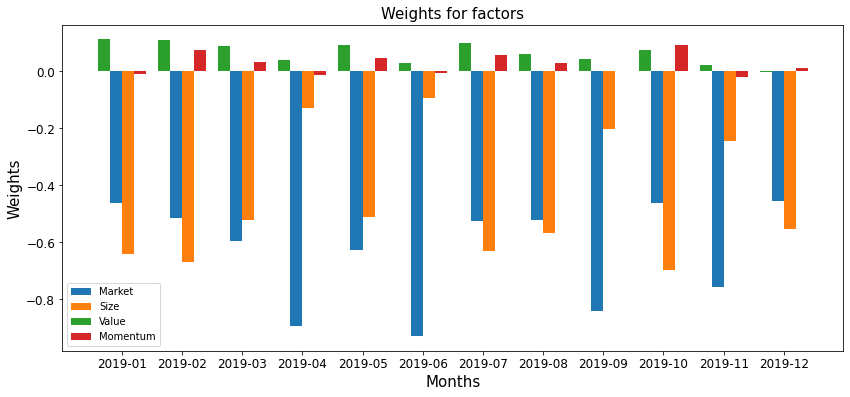

In [ ]:
ind = final_time_frame[:12]
X_axis = np.arange(len(ind))

plt.figure(figsize = (14, 6))
plt.bar(X_axis - 0.1, mkt_weights, 0.2, label = 'Market')
plt.bar(X_axis + 0.1, size_weights, 0.2, label = 'Size')
plt.bar(X_axis - 0.3, value_weights, 0.2, label = 'Value')
plt.bar(X_axis + 0.3, mom_weights, 0.2, label = 'Momentum')
plt.legend()
plt.title("Weights for factors", fontsize = 15)
plt.xlabel("Months", fontsize = 15)
plt.ylabel("Weights", fontsize = 15)
plt.xticks(ticks = X_axis, labels = list(ind), fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Market Sectors

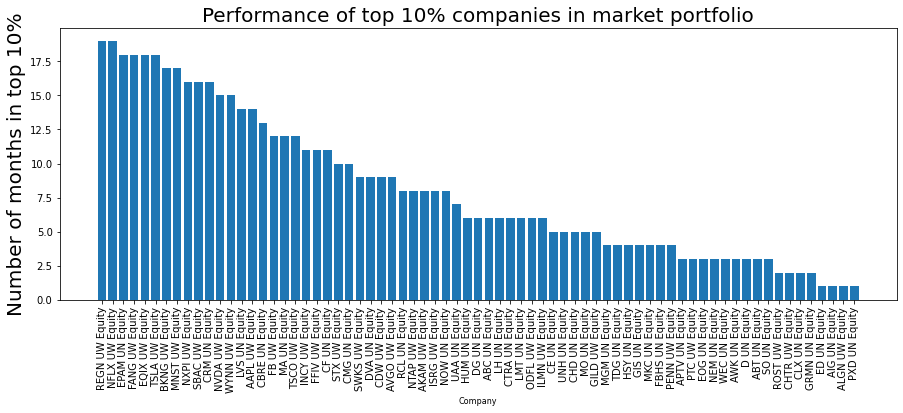

In [ ]:
flat_mkt_top = list(itertools.chain(*mkt_top))
dict_mkt_top = dict(Counter(flat_mkt_top))
dict_mkt_top = {k: v for k, v in sorted(dict_mkt_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mkt_top.keys(), dict_mkt_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in market portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 8)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

EPAM corresponding sector not found



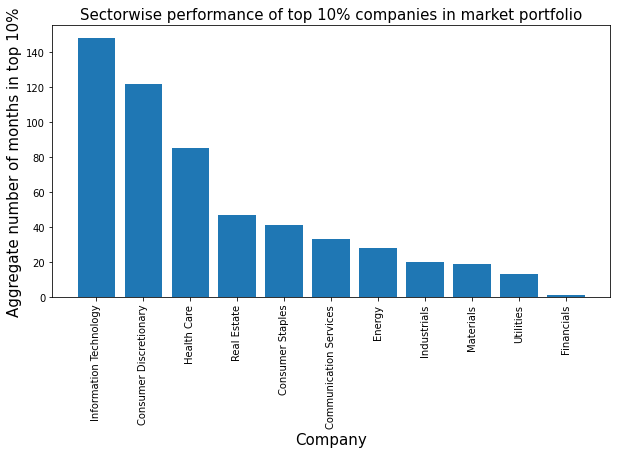

In [ ]:
sector_dict_mkt_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mkt_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mkt_top[company_key_dict[name]] = sector_dict_mkt_top[company_key_dict[name]] + dict_mkt_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mkt_top = {k: v for k, v in sorted(sector_dict_mkt_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mkt_top.keys(), sector_dict_mkt_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in market portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

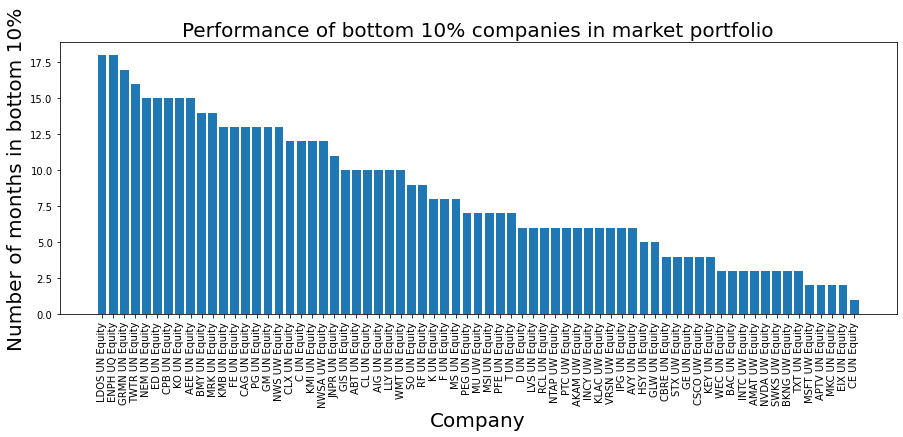

In [ ]:
flat_mkt_bottom = list(itertools.chain(*mkt_bottom))
dict_mkt_bottom = dict(Counter(flat_mkt_bottom))
dict_mkt_bottom = {k: v for k, v in sorted(dict_mkt_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mkt_bottom.keys(), dict_mkt_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in market portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

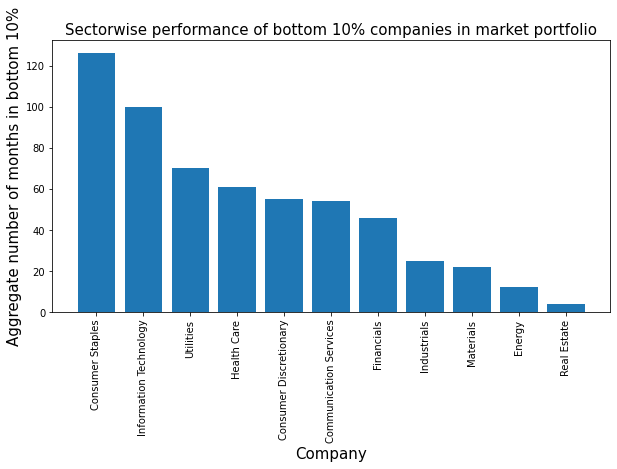

In [ ]:
sector_dict_mkt_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mkt_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mkt_bottom[company_key_dict[name]] = sector_dict_mkt_bottom[company_key_dict[name]] + dict_mkt_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mkt_bottom = {k: v for k, v in sorted(sector_dict_mkt_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mkt_bottom.keys(), sector_dict_mkt_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in market portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Value Sectors

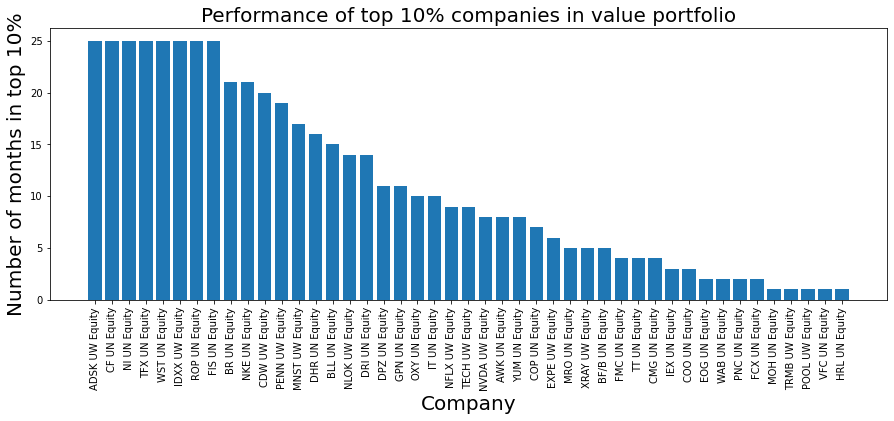

In [ ]:
flat_value_top = list(itertools.chain(*value_top))
dict_value_top = dict(Counter(flat_value_top))
dict_value_top = {k: v for k, v in sorted(dict_value_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_value_top.keys(), dict_value_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in value portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

BF/B corresponding sector not found
MOH corresponding sector not found



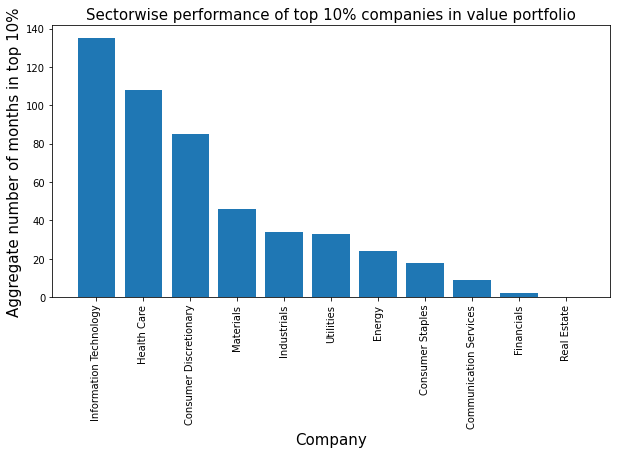

In [ ]:
sector_dict_value_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_value_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_value_top[company_key_dict[name]] = sector_dict_value_top[company_key_dict[name]] + dict_value_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_value_top = {k: v for k, v in sorted(sector_dict_value_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_value_top.keys(), sector_dict_value_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in value portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

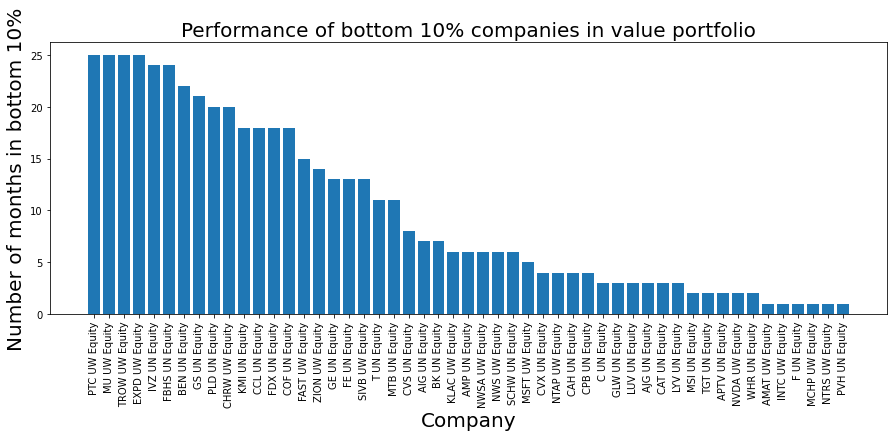

In [ ]:
flat_value_bottom = list(itertools.chain(*value_bottom))
dict_value_bottom = dict(Counter(flat_value_bottom))
dict_value_bottom = {k: v for k, v in sorted(dict_value_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_value_bottom.keys(), dict_value_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in value portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

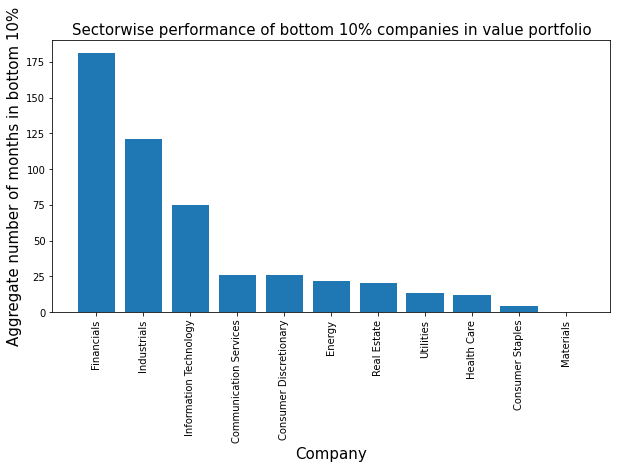

In [ ]:
sector_dict_value_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_value_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_value_bottom[company_key_dict[name]] = sector_dict_value_bottom[company_key_dict[name]] + dict_value_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_value_bottom = {k: v for k, v in sorted(sector_dict_value_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_value_bottom.keys(), sector_dict_value_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in value portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Size Sectors

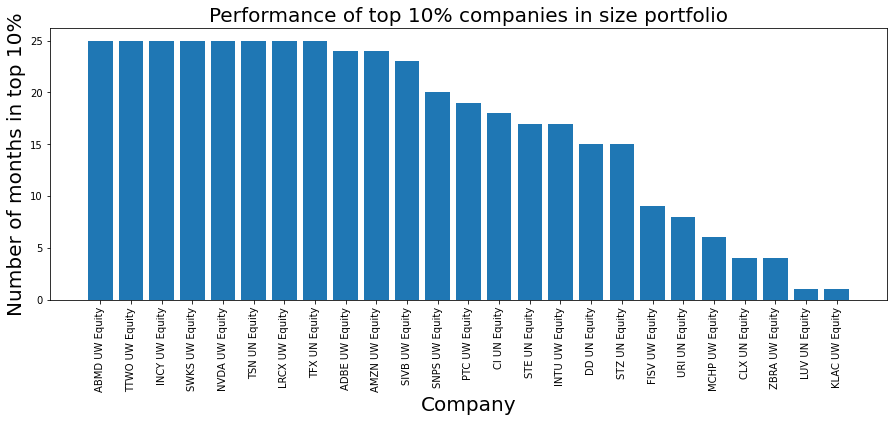

In [ ]:
flat_size_top = list(itertools.chain(*size_top))
dict_size_top = dict(Counter(flat_size_top))
dict_size_top = {k: v for k, v in sorted(dict_size_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_size_top.keys(), dict_size_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in size portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.show()

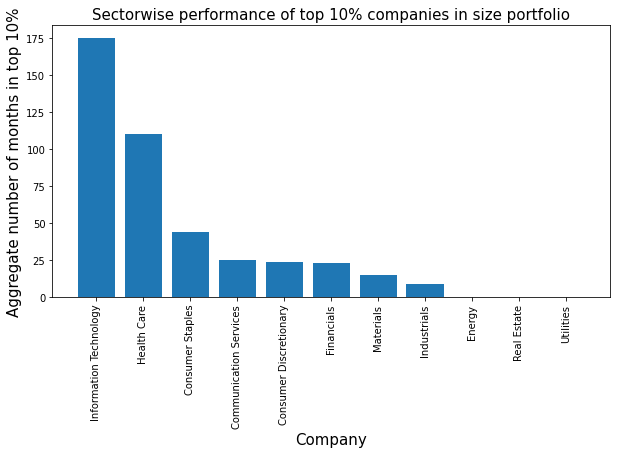

In [ ]:
sector_dict_size_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_size_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_size_top[company_key_dict[name]] = sector_dict_size_top[company_key_dict[name]] + dict_size_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_size_top = {k: v for k, v in sorted(sector_dict_size_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_size_top.keys(), sector_dict_size_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in size portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

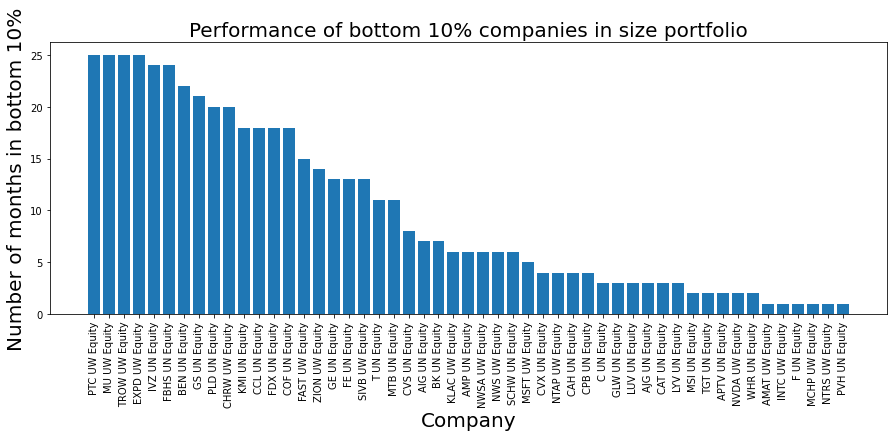

In [ ]:
flat_size_bottom = list(itertools.chain(*size_bottom))
dict_size_bottom = dict(Counter(flat_value_bottom))
dict_size_bottom = {k: v for k, v in sorted(dict_size_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_size_bottom.keys(), dict_size_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in size portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.show()

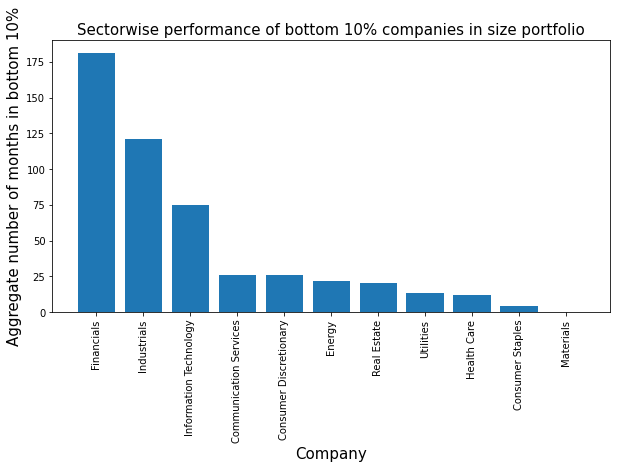

In [ ]:
sector_dict_size_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_size_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_size_bottom[company_key_dict[name]] = sector_dict_size_bottom[company_key_dict[name]] + dict_size_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_size_bottom = {k: v for k, v in sorted(sector_dict_size_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_size_bottom.keys(), sector_dict_size_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in size portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

## Momentum Sectors

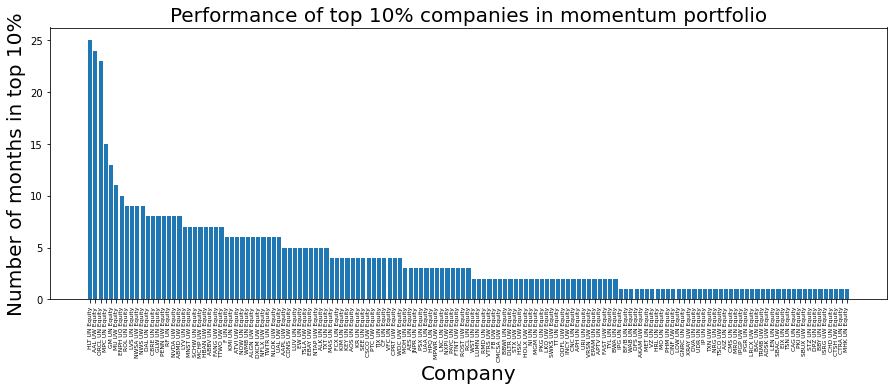

In [ ]:
flat_mom_top = list(itertools.chain(*mom_top))
dict_mom_top = dict(Counter(flat_mom_top))
dict_mom_top = {k: v for k, v in sorted(dict_mom_top.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mom_top.keys(), dict_mom_top.values())
plt.xticks(rotation = 90)
plt.title("Performance of top 10% companies in momentum portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in top 10%", fontsize = 20)
plt.xticks(fontsize = 6)
plt.show()

MOH corresponding sector not found
EPAM corresponding sector not found
BF/B corresponding sector not found



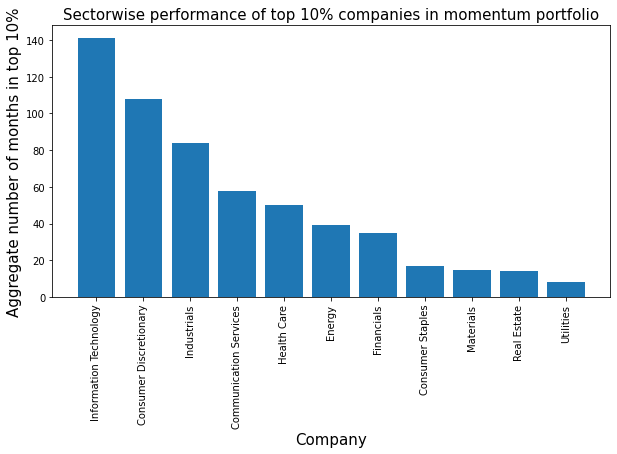

In [ ]:
sector_dict_mom_top = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mom_top:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mom_top[company_key_dict[name]] = sector_dict_mom_top[company_key_dict[name]] + dict_mom_top[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mom_top = {k: v for k, v in sorted(sector_dict_mom_top.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mom_top.keys(), sector_dict_mom_top.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of top 10% companies in momentum portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in top 10%", fontsize = 15)
plt.show()

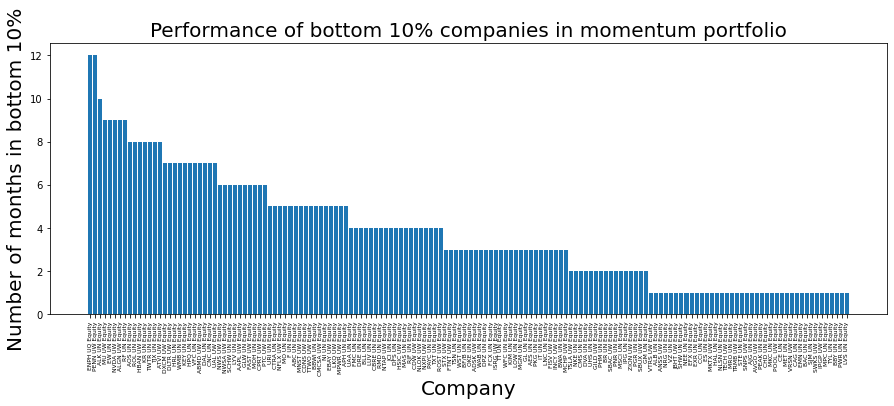

In [ ]:
flat_mom_bottom = list(itertools.chain(*mom_bottom))
dict_mom_bottom = dict(Counter(flat_mom_bottom))
dict_mom_bottom = {k: v for k, v in sorted(dict_mom_bottom.items(), key=lambda item: item[1], reverse = True)}

plt.figure(figsize=(15,5))
plt.bar(dict_mom_bottom.keys(), dict_mom_bottom.values())
plt.xticks(rotation = 90)
plt.title("Performance of bottom 10% companies in momentum portfolio", fontsize = 20)
plt.xlabel("Company", fontsize = 20)
plt.ylabel("Number of months in bottom 10%", fontsize = 20)
plt.xticks(fontsize = 6)
plt.show()

MOH corresponding sector not found
BF/B corresponding sector not found



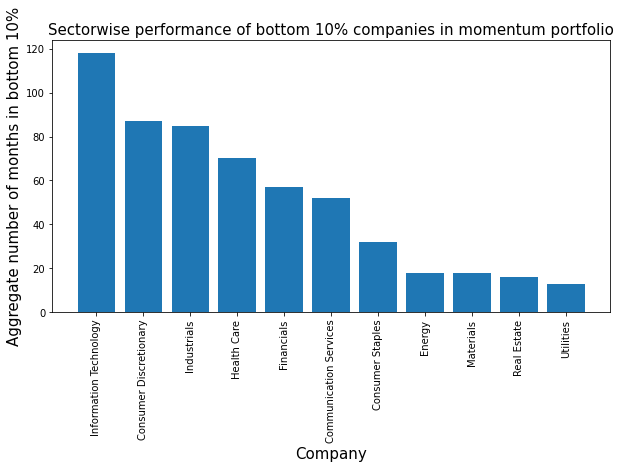

In [ ]:
sector_dict_mom_bottom = {key: 0 for key in sector_key_dict.keys()}

for v in dict_mom_bottom:
  name = v.split(' ')[0]
  if name in company_key_dict.keys():
    sector_dict_mom_bottom[company_key_dict[name]] = sector_dict_mom_bottom[company_key_dict[name]] + dict_mom_bottom[v]
  else:
    print(name, "corresponding sector not found")

sector_dict_mom_bottom = {k: v for k, v in sorted(sector_dict_mom_bottom.items(), key=lambda item: item[1], reverse = True)}


print()
plt.figure(figsize=(10,5))
plt.bar(sector_dict_mom_bottom.keys(), sector_dict_mom_bottom.values())
plt.xticks(rotation = 90)
plt.title("Sectorwise performance of bottom 10% companies in momentum portfolio", fontsize = 15)
plt.xlabel("Company", fontsize = 15)
plt.ylabel("Aggregate number of months in bottom 10%", fontsize = 15)
plt.show()

# **PERFORMANCE COMPARISION**

## Market Benchmark

In [ ]:
# S&P 500 core ETF (for market) 

sp500etf = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/IVV.csv')
sp500etf['Date'] = pd.to_datetime(sp500etf['Date'].astype(str),format='%Y-%m-%d')
sp500etf.set_index('Date',inplace= True)
sp500etf=pd.DataFrame(sp500etf['Adj Close'].values,index=sp500etf.index, columns = ["Returns"])
sp500etf = sp500etf.loc["2019-01-01":]
print("Dimension of SP500 core ETF data:", sp500etf.shape, "\n")
sp500etf.head(5)

Dimension of SP500 core ETF data: (251, 1) 



,Returns
Date,
2019-01-02,237.704132
2019-01-03,231.764359
2019-01-04,239.913818
2019-01-07,241.528610
2019-01-08,243.908310


In [ ]:
sp500etf['month_date'] = pd.to_datetime(sp500etf.index).strftime('%Y-%m')
sp500etf = sp500etf.groupby("month_date").mean()
mreturn_ = sp500etf.pct_change()
cum_return_mkt=np.cumprod(1+mreturn_)
print("Cumulative returns using market benchmark:", round((cum_return_mkt.loc["2019-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using market benchmark: 23.9853 %


## Value Benchmark

In [ ]:
# iShares MSCI USA Value Factor ETF

value = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/VLUE.csv')
value['Date'] = pd.to_datetime(value['Date'].astype(str),format='%Y-%m-%d')
value.set_index('Date',inplace= True)
value=pd.DataFrame(value['Adj Close'].values,index=value.index, columns = ["Returns"])
value = value["2019-01-01":]
print("Dimension of Value ETF data:", value.shape, "\n")
value.head()

Dimension of Value ETF data: (251, 1) 



,Returns
Date,
2019-01-02,67.126305
2019-01-03,65.853729
2019-01-04,68.160858
2019-01-07,68.948212
2019-01-08,69.415131


In [ ]:
value['month_date'] = pd.to_datetime(value.index).strftime('%Y-%m')
value = value.groupby("month_date").mean()
mreturn_ = value.pct_change()
cum_return_value=np.cumprod(1+mreturn_)
print("Cumulative returns using value benchmark:", round((cum_return_value.loc["2019-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using value benchmark: 17.7038 %


## Size Benchmark

In [ ]:
# iShares MSCI USA Size Factor ETF

size = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/SIZE.csv')
size['Date'] = pd.to_datetime(size['Date'].astype(str),format='%Y-%m-%d')
size.set_index('Date',inplace= True)
size=pd.DataFrame(size['Adj Close'].values,index=size.index, columns = ["Returns"])
size = size["2019-01-01":]
print("Dimension of Size ETF data:", size.shape, "\n")
size.head()

Dimension of Size ETF data: (251, 1) 



,Returns
Date,
2019-01-02,72.785324
2019-01-03,71.433891
2019-01-04,73.879730
2019-01-07,74.764816
2019-01-08,75.526176


In [ ]:
size['month_date'] = pd.to_datetime(size.index).strftime('%Y-%m')
size = size.groupby("month_date").mean()
mreturn_ = size.pct_change()
cum_return_size=np.cumprod(1+mreturn_)
print("Cumulative returns using size benchmark:", round((cum_return_size.loc["2019-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using size benchmark: 20.3665 %


## Momentum Benchmark

In [ ]:
# SPDR S&P 1500 Momentum Tilt ETF (for momentum) 

mmtm = pd.read_csv('https://raw.githubusercontent.com/sukritik/Opti-modelling-/main/MMTM.csv')
mmtm['Date'] = pd.to_datetime(mmtm['Date'].astype(str),format='%Y-%m-%d')
mmtm.set_index('Date',inplace= True)
mmtm=pd.DataFrame(mmtm['Adj Close'].values,index=mmtm.index, columns = ["Returns"])
mmtm = mmtm["2019-01-01":]
print("Dimension of Momentum ETF data:", mmtm.shape, "\n")
mmtm.head()

Dimension of Momentum ETF data: (251, 1) 



,Returns
Date,
2019-01-02,103.478615
2019-01-03,100.830727
2019-01-04,104.332466
2019-01-07,105.272652
2019-01-08,106.481476


In [ ]:
mmtm['month_date'] = pd.to_datetime(mmtm.index).strftime('%Y-%m')
mmtm = mmtm.groupby("month_date").mean()
mreturn_ = mmtm.pct_change()
cum_return_mom=np.cumprod(1+mreturn_)
print("Cumulative returns using momentum benchmark:", round((cum_return_mom.loc["2019-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using momentum benchmark: 22.6632 %


## Our Portfolio

In [ ]:
df_final_returns=pd.DataFrame(final_returns,index=final_time_frame[:len(final_time_frame)-1], columns = ["Returns"])
df_final_returns = df_final_returns.loc["2019-02":]
cum_final_return=np.cumprod(1+df_final_returns)
print("Cumulative returns using momentum benchmark:", round((cum_final_return.loc["2019-12"]["Returns"] - 1)*100, 4), "%")

Cumulative returns using momentum benchmark: 62.7081 %


In [ ]:
print("Cumulative Returns at each time step:")
cum_final_return

Cumulative Returns at each time step:


,Returns
month_date,
2019-02,1.579782
2019-03,1.778248
2019-04,2.420429
2019-05,0.801337
2019-06,0.395339
2019-07,0.607638
2019-08,0.410331
2019-09,0.665452
2019-10,0.423494


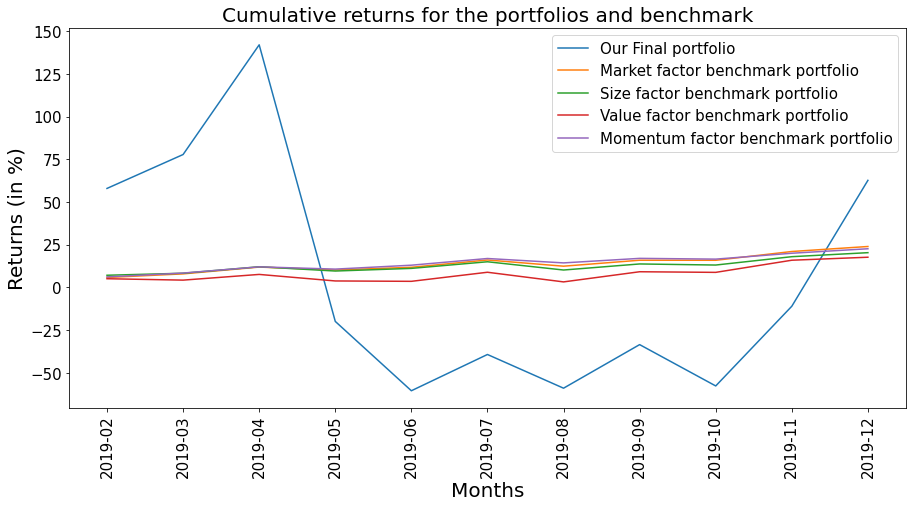

In [ ]:
plt.figure(figsize=(15,7))
plt.plot((cum_final_return-1)*100,label='Our Final portfolio')
plt.plot((cum_return_mkt-1)*100,label='Market factor benchmark portfolio')
plt.plot((cum_return_size-1)*100,label='Size factor benchmark portfolio')
plt.plot((cum_return_value-1)*100,label='Value factor benchmark portfolio')
plt.plot((cum_return_mom-1)*100,label='Momentum factor benchmark portfolio')
plt.title('Cumulative returns for the portfolios and benchmark', fontsize = 20)
plt.xlabel("Months", fontsize = 20)
plt.ylabel("Returns (in %)", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# **(FUTURE WORKS)**

In [ ]:
# # Markowitz model

# def Markowitz_weighted(cov, N, n_arr):
#   n1, n2, n3, n4 = n_arr[0], n_arr[1], n_arr[2], n_arr[3]
#   w = cp.Variable(N)
#   mu = np.abs(np.random.randn(N, 1))
#   ret = mu.T@w 
#   risk = cp.quad_form(w, cov)
#   prob = cp.Problem(cp.Maximize(ret - risk), [cp.sum(w[0:n1]) == 1, cp.sum(w[n1:n1+n2]) == 1, cp.sum(w[n1+n2:n1+n2+n3]) == 1, cp.sum(w[n1+n2+n3:N-4]) == 1, cp.sum(w[N-4:N]) == 1])
#   result = prob.solve()
#   return w.value

# # Uncertainity Ratio tau
# mkt_conf = 90
# value_conf = 90
# size_conf = 90
# mom_conf = 90
# avg_conf = (mkt_conf + value_conf + size_conf + mom_conf)/4
# tau = (100-avg_conf)/100

# test_time_frame = return_.loc['2018-01':].index
# index = -1

# for t in test_time_frame:

#   index = index + 1

#   # Input view_dict for Black Litterman
#   views = [mkt_view.loc[t]["new_forecast"], value_view.loc[t]["new_forecast"], 
#            size_view.loc[t]["new_forecast"], mom_view.loc[t]["new_forecast"]]

#   # Make list of n (n1+n2+n3+n4) stocks to be used in total
#   mkt_stock = [item for sublist in [mkt_top[index], mkt_bottom[index]] for item in sublist]
#   value_stock = [item for sublist in [value_top[index], value_bottom[index]] for item in sublist]
#   size_stock = [item for sublist in [size_top[index], size_bottom[index]] for item in sublist]
#   mom_stock = [item for sublist in [mom_top[index], mom_bottom[index]] for item in sublist]
#   n1 = len(mkt_stock)
#   n2 = len(value_stock)
#   n3 = len(size_stock)
#   n4 = len(mom_stock)
#   n = n1 + n2 + n3 + n4

#   # Make covariance matrix of stocks
#   mkt_1 = return_[:'2017-12'][mkt_stock]
#   mkt_2 = mkt_test_forecast.loc[:t][mkt_stock]
#   mkt_port = mkt_1.append(mkt_2)
#   value_1 = return_[:'2017-12'][value_stock]
#   value_2 = value_test_forecast.loc[:t][value_stock]
#   value_port = value_1.append(value_2)
#   size_1 = return_[:'2017-12'][size_stock]
#   size_2 = size_test_forecast.loc[:t][size_stock]
#   size_port = size_1.append(size_2)
#   mom_1 = return_[:'2017-12'][mom_stock]
#   mom_2 = mom_test_forecast.loc[:t][mom_stock]
#   mom_port = mom_1.append(mom_2)
#   temp1 = mkt_port.join(value_port, on='month_date', lsuffix = '_mkt', rsuffix='_value')
#   temp2 = temp1.join(size_port, on='month_date', rsuffix='_size')
#   port_n = temp2.join(mom_port, on='month_date', rsuffix='_mom')
#   port_n = port_n.fillna(0)  
#   sigma_n = port_n.cov()

#   # Factor loadings
#   B = np.zeros((n, 4))
#   w = [0.5*(0.518790)**i for i in np.arange(0,11)]
#   B[0:n1,0] = [mkt_param[k][1] for k in mkt_stock]
#   B[n1:n1+n2,1] = [value_param[k][1] for k in value_stock]
#   B[n1+n2:n1+n2+n3,2] = [size_param[k][1] for k in size_stock]
#   B[n1+n2+n3:n, 3] = [np.mean(mom_param[k][1:]*w) for k in mom_stock]

#   # Make covariance matrix of factors
#   mkt_1 = train_forecast(mkt_train_forecast, mkt_top[index], mkt_bottom[index], "new_forecast")
#   mkt_2 = pd.DataFrame(mkt_view.loc[:t]["new_forecast"])
#   mkt_port = mkt_1.append(mkt_2)
#   value_1 = train_forecast(value_train_forecast, value_top[index], value_bottom[index], "new_forecast")
#   value_2 = pd.DataFrame(value_view.loc[:t]["new_forecast"])
#   value_port = value_1.append(value_2)
#   size_1 = train_forecast(size_train_forecast, size_top[index], size_bottom[index], "new_forecast")
#   size_2 = pd.DataFrame(size_view.loc[:t]["new_forecast"])
#   size_port = size_1.append(size_2)
#   mom_1 = train_forecast(mom_train_forecast, mom_top[index], mom_bottom[index], "new_forecast")
#   mom_2 = pd.DataFrame(mom_view.loc[:t]["new_forecast"])
#   mom_port = mom_1.append(mom_2)
#   temp1 = mkt_port.join(value_port, on='month_date', lsuffix = '_mkt', rsuffix='_value')
#   temp2 = temp1.join(size_port, on='month_date', rsuffix='_size')
#   port_f = temp2.join(mom_port, on='month_date', rsuffix='_mom')
#   port_f = port_f.fillna(0) 
#   port_f = port_f.rename(columns={'new_forecast': 'new_forecast_size'})
#   sigma_f = port_f.cov()

#   # Combine above 3 to form SIGMA
#   N = n+4
#   SIGMA = np.zeros((N, N))
#   SIGMA[0:n, 0:n] = sigma_n
#   SIGMA[0:n, n:N] = np.matmul(B, sigma_f)
#   SIGMA[n:N, 0:n] = np.matmul(B, sigma_f).T
#   SIGMA[n:N, n:N] = sigma_f

#   # Make mapping matrix
#   P = np.zeros((4, N))
#   P[0, 0:n1] = np.ones(n1)
#   P[0, n] = 1
#   P[1, n1:n1+n2] = np.ones(n2)
#   P[1, n+1] = 1
#   P[2, n1+n2:n1+n2+n3] = np.ones(n3)
#   P[2, n+2] = 1
#   P[3, n1+n2+n3:n] = np.ones(n4)
#   P[3, n+3] = 1

#   # Make Omega
#   omega = port_f
#   omega['new_forecast_mkt'] = port_f['new_forecast_mkt'].apply(lambda x: x*((100-mkt_conf)/100))
#   omega['new_forecast_value'] = port_f['new_forecast_value'].apply(lambda x: x*((100-mkt_conf)/100))
#   omega['new_forecast_size'] = port_f['new_forecast_size'].apply(lambda x: x*((100-mkt_conf)/100))
#   omega['new_forecast_mom'] = port_f['new_forecast_mom'].apply(lambda x: x*((100-mkt_conf)/100))
#   Omega = omega.cov()

#   # Input cov_mat for Black Litterman
#   intermediate1 = np.linalg.inv(tau*SIGMA)
#   intermediate2 = np.matmul(P.T, np.matmul(np.linalg.inv(Omega), P))
#   cov_mat = np.linalg.inv(intermediate1 +  intermediate2)

#   cov_mat_sym = (cov_mat + cov_mat.T)/2
#   cov_mat_psd = np.matmul(cov_mat_sym, cov_mat_sym.T)
#   weights = Markowitz_weighted(cov_mat_psd, n+4, [n1, n2, n3, n4])
#   print(weights)

#   print("Time instance:", t)
#   print("Views of length:", len(views))
#   print("Covariance matrix of dimension:", cov_mat.shape)
#   print()